In [1]:
import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
#from datetime import datetime

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.experimentclasses.RigidEthanolPCA2 import RigidEthanolPCA2
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell

from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle

def plot_watch_custom(to_plot, p, ax,colors):
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = r"$g_{{{}}}$".format(j),color=colors[j],#cmap.colors[j],
                  fontdict = {'fontsize' : 70},
                  horizontalalignment='center',
         verticalalignment='center')



        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 200*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 40})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')

                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()
    ax.set_title(r"$\omega = 25$")
    
def plot_cosines(cosines, ax, colors):
    p = cosines.shape[0]
    sns.heatmap(cosines ,ax = ax, vmin = 0., vmax = 1.)
#    ax = sns.heatmap(x, cmap=cmap)
    # use matplotlib.colorbar.Colorbar object
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)

    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 500 / p)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 500 / p)
    
    ax.set_ylabel(r"$g_{j'}$", fontsize = 70)
    ax.set_xlabel(r"$g_{j}$", fontsize = 70)
    #ax.set_title(r"$\text{hi}$")
    ax.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_j (\xi_i) \|_2 \| grad_{\mathcal M} g_{j'}(\xi_i) \|_2} $",
                fontsize = 70)

# def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
#     p = coeffs.shape[3]
#     q = coeffs.shape[1]
#     gnames = np.asarray(list(range(p)), dtype=str)

#     rcParams['axes.titlesize'] = 30
#     plt.rc('text', usetex=True)

#     normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

#     for j in range(p):
#         toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
#         # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
#         ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
#                      color=colors[j], label=gnames[j])

#     kkk = xaxis.copy()
#     kkk.sort()

#     # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

#     #for k in range(1 + q):
#     ax.tick_params(labelsize=50)
#     ax.set_xscale('symlog')
#     ax.set_yscale('symlog')
#     ax.set_ylim(bottom=0, top=normax)
#     # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
#     #if (k == 0):
#     tixx = np.hstack(
#         [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
# #    if k != 0:
#         # axes[k].set_yticks(tixx)
#     ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
#     ax.set_xlabel(r"$\lambda  $", fontsize = 70)#\sqrt{nm}
#     #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
#     #ax.l
#     #if k == 0:
#     #ax.set_title("Combined", fontdict={'fontsize': 50})
#     ax.grid(True, which="both", alpha=True)

#     #handles, labels = ax.get_legend_handles_labels()
#     #by_label = OrderedDict(zip(labels, handles))
#     # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
#     # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
#     #fig.subplots_adjust(right=0.75)
#     #leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
#     #leg_ax.axis('off')
#     #leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
#     # leg.set_title('Torsion', prop={'size': Function})
#     #for l in leg.get_lines():
#     #    l.set_alpha(1)
#     # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
#     #    nreps))
    

def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
            #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
        
    axes[0].set_ylabel(r"$\|\beta\|$", fontsize = 50)
        
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    fig.subplots_adjust(right=0.75)
    leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    leg_ax.axis('off')
    leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    for l in leg.get_lines():
        l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))


    
def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm)

#set parameters
n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
tol = 1e-14 #convergence criteria for lasso
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
diffusion_time = 0.05 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.0001 #variance scaler for noise
cor = 0.0 #correlation for noise
var = 10. #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/rigidethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)


/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:
from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
import math
from sklearn.decomposition import TruncatedSVD
from pathos.multiprocessing import ProcessingPool as Pool

In [3]:
#this is for use with full dictionaries
#all points are members of a different irrational field
#in order to avoid set of measure zero
#in the noiseless case
from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
import math
from sklearn.decomposition import TruncatedSVD
from pathos.multiprocessing import ProcessingPool as Pool

class RigidEthanolPCA2(AtomicRegression):
    """
    Parameters
    ----------
    cor : string,
        Data file to load
    xvar : np.array(dtype = int),
        List of adjacencies
    jj : np.array,
        List of adjacencies part 2
    d : int,
        dimension over which to evaluate the radii (smaller usually better)
    rmin : float,
        smallest radius ( = rad_bw_ratio * bandwidth) to consider
    rmax : float,
        largest radius ( = rad_bw_ratio * bandwidth) to consider
    ntry : int,
        number of radii between rmax and rmin to try
    run_parallel : bool,
        whether to run the analysis in parallel over radii
    search_space : str,
        either 'linspace' or 'logspace', choose to search in log or linear space
    rad_bw_ratio : float,
        the ratio of radius and kernel bandwidth, default to be 3 (radius = 3*h)
    Methods
    -------
    generate_data :
        Simulates data
    get_atoms_4 :
    	Gets atomic tetrahedra based off of ii and jj
    get_atoms_3 :
    	Gets triples of atoms

    """

    # AtomicRegression(dim, ii, jj, filename)
    def __init__(self, dim, cor, xvar,ii,jj, cores, noise, custom_bonds = None):
        natoms = 9
        n = 10000
        self.cor = cor
        self.xvar = xvar
        self.cores = cores
        self.noise = noise
        AtomicRegression.__init__(self, dim,n,ii,jj, natoms, cores)
        if custom_bonds.any() != None:
            self.atoms4 = custom_bonds
            self.p = custom_bonds.shape[0]

    def generate_data(self, noise=False):
        
        
        n = self.n
        d = self.d
        cor = self.cor
        xvar = self.xvar
        natoms = self.natoms
        cores = self.cores
        atoms3 = self.atoms3
        dim = self.dim
        #noise = self.noise

        positions = np.zeros((n, 9, 3))
        # positions[0,0,:] = np.asarray([0.,0.,0.])
        # positions[0,1,:] = np.asarray([-10.,0.,0.])
        # positions[0,2,:] = np.asarray([1.,10.,0.])
        # #positions[0,8,:] = np.asarray([1.,1.,0.])
        # positions[0,8,:] = np.asarray([2.,10.,-0])
        # positions[0,3,:] = np.asarray([1., np.cos(2/3 * np.pi), np.sin(2/3 * np.pi)])
        # positions[0,4,:] = np.asarray([1., np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        # positions[0,5,:] = np.asarray([-12.,1.,0.])
        # positions[0,6,:] = np.asarray([-12., np.cos(2/3 * np.pi),np.sin(2/3 * np.pi)])
        # positions[0,7,:] = np.asarray([-12.,np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        positions[0,0,:] = np.asarray([0.,0.,0.])
        positions[0,1,:] = np.asarray([-10.,0.,np.sqrt(2)/100])
        positions[0,2,:] = np.asarray([0.,10.,np.sqrt(3)/100])
        #positions[0,8,:] = np.asarray([1.,1.,0.])
        positions[0,8,:] = np.asarray([1.,10.,np.sqrt(5)/100])
        positions[0,3,:] = np.asarray([np.sqrt(7)/100, np.cos(2/3 * np.pi), np.sin(2/3 * np.pi)])
        positions[0,4,:] = np.asarray([np.sqrt(11)/100, np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        positions[0,5,:] = np.asarray([-11.,1.,np.sqrt(13)/100])
        positions[0,6,:] = np.asarray([-11. , np.cos(2/3 * np.pi)+ np.sqrt(17)/1000,np.sin(2/3 * np.pi) ])
        positions[0,7,:] = np.asarray([-11., np.cos(2/3 * np.pi)+ np.sqrt(19)/100, np.sin(4/3 * np.pi)])

        angles1 = np.tile(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False),
                          int(np.sqrt(n)))
        angles2 = np.repeat(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False),
                            int(np.sqrt(n)))
        for i in range(1, n):
            rotationmatrix1 = np.zeros((3, 3))
            rotationmatrix1[1, 1] = 1
            rotationmatrix1[0, 0] = np.cos(angles1[i])
            rotationmatrix1[0, 2] = -np.sin(angles1[i])
            rotationmatrix1[2, 2] = np.cos(angles1[i])
            rotationmatrix1[2, 0] = np.sin(angles1[i])
            rotationmatrix2 = np.zeros((3, 3))
            rotationmatrix2[0, 0] = 1
            rotationmatrix2[1, 1] = np.cos(angles2[i])
            rotationmatrix2[1, 2] = -np.sin(angles2[i])
            rotationmatrix2[2, 2] = np.cos(angles2[i])
            rotationmatrix2[2, 1] = np.sin(angles2[i])
            positions[i, np.asarray([3, 4]), :] = positions[0, np.asarray([3, 4]), :]
            positions[i, np.asarray([2, 8]), :] = np.matmul(rotationmatrix1,
                                                            positions[0, np.asarray([2, 8]),
                                                            :].transpose()).transpose()
            positions[i, np.asarray([1, 5, 6, 7]), :] = np.matmul(rotationmatrix2,
                                                                  positions[0, np.asarray([1, 5, 6, 7]),
                                                                  :].transpose()).transpose()

        covariance = np.identity(natoms)
        for i in range(natoms):
            for j in range(natoms):
                if i != j:
                    covariance[i, j] = cor
        covariance = xvar * covariance
        print(covariance)
        if noise == True:
            for i in range(n):
                for j in range(3):
                    
                    positions[i, :, j] = np.random.multivariate_normal(positions[i, :, j], covariance, size=1)
        self.positions = positions
        p = Pool(cores)
        results = p.map(lambda i: compute3angles(position=positions[i[0], atoms3[i[1]], :]),
                            data_stream(10000, 84))
        data = np.reshape(results, (n, (d)))
        svd = TruncatedSVD(n_components=50)
        svd.fit(data)
        data_pca = svd.transform(data)
        return (RiemannianManifold(data, dim), RiemannianManifold(data_pca,dim), svd.components_)
    
def plot_watch_custom(to_plot, p, ax,colors):
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = r"$g_{{{}}}$".format(j),color=colors[j],#cmap.colors[j],
                  fontdict = {'fontsize' : 70},
                  horizontalalignment='center',
         verticalalignment='center')



        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 200*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 40})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')

                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()
    ax.set_title(r"$\omega = 25$")
    
def plot_cosines(cosines, ax, colors):
    p = cosines.shape[0]
    sns.heatmap(cosines ,ax = ax, vmin = 0., vmax = 1.)
#    ax = sns.heatmap(x, cmap=cmap)
    # use matplotlib.colorbar.Colorbar object
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)

    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 500 / p)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 500 / p)
    
    ax.set_ylabel(r"$g_{j'}$", fontsize = 70)
    ax.set_xlabel(r"$g_{j}$", fontsize = 70)
    #ax.set_title(r"$\text{hi}$")
    ax.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_j (\xi_i) \|_2 \| grad_{\mathcal M} g_{j'}(\xi_i) \|_2} $",
                fontsize = 70)

# def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
#     p = coeffs.shape[3]
#     q = coeffs.shape[1]
#     gnames = np.asarray(list(range(p)), dtype=str)

#     rcParams['axes.titlesize'] = 30
#     plt.rc('text', usetex=True)

#     normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

#     for j in range(p):
#         toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
#         # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
#         ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
#                      color=colors[j], label=gnames[j])

#     kkk = xaxis.copy()
#     kkk.sort()

#     # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

#     #for k in range(1 + q):
#     ax.tick_params(labelsize=50)
#     ax.set_xscale('symlog')
#     ax.set_yscale('symlog')
#     ax.set_ylim(bottom=0, top=normax)
#     # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
#     #if (k == 0):
#     tixx = np.hstack(
#         [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
# #    if k != 0:
#         # axes[k].set_yticks(tixx)
#     ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
#     ax.set_xlabel(r"$\lambda  $", fontsize = 70)#\sqrt{nm}
#     #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
#     #ax.l
#     #if k == 0:
#     #ax.set_title("Combined", fontdict={'fontsize': 50})
#     ax.grid(True, which="both", alpha=True)

#     #handles, labels = ax.get_legend_handles_labels()
#     #by_label = OrderedDict(zip(labels, handles))
#     # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
#     # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
#     #fig.subplots_adjust(right=0.75)
#     #leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
#     #leg_ax.axis('off')
#     #leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
#     # leg.set_title('Torsion', prop={'size': Function})
#     #for l in leg.get_lines():
#     #    l.set_alpha(1)
#     # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
#     #    nreps))
    

def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
            #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
        
    axes[0].set_ylabel(r"$\|\beta\|$", fontsize = 50)
        
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    fig.subplots_adjust(right=0.75)
    leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    leg_ax.axis('off')
    leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    for l in leg.get_lines():
        l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))



In [4]:
new_MN = True
new_grad = True
savename = 'rigidethanol_jmlrresub'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_jmlrresub'
var = 0.000001#var = 0.01 breaks
if new_MN == True:
    experiment = RigidEthanolPCA2(dim, cor, var, ii, jj, cores, True, atoms4)
    experiment.M, experiment.Mpca, projector = experiment.generate_data(noise=True)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)
    # with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
    #          'wb') as output:
    #      pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)

atoms4,p = get_atoms_4(natoms,ii,jj)
experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))



[[1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06]]


In [6]:
nsel

100

In [7]:
print('pre-gradient acquisition')
print(datetime.datetime.now())
for i in range(nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)

pre-gradient acquisition
2021-01-18 11:08:48.656657
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [8]:

savename = 'rigidethanol_010521_p12rep5n500_papernorm_noise_p0001'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_010521_p12rep5n500_papernorm_noise_p0001'

# with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'replicates.pkl' ,
#          'wb') as output:
#      pickle.dump(replicates, output, pickle.HIGHEST_PROTOCOL)


selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

from pathos.multiprocessing import ProcessingPool as Pool
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))

results = {}
for r in range(nreps):
    print(r)
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


# with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'results.pkl' ,
#          'wb') as output:
#      pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

print('done')
print(datetime.datetime.now())

pre-gradient descent
2021-01-18 11:21:24.264537
0
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
2
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30

lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390


209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125


lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.

lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483


296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125


lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197


23
lr 0.00152587890625
24
lr 0.00152587890625
25
lr 0.00152587890625
26
lr 0.00152587890625
27
lr 0.00152587890625
28
lr 0.00152587890625
29
lr 0.00152587890625
30
lr 0.00152587890625
31
lr 0.00152587890625
32
lr 0.00152587890625
33
lr 0.00152587890625
34
lr 0.00152587890625
35
lr 0.00152587890625
36
lr 0.00152587890625
37
lr 0.00152587890625
38
lr 0.00152587890625
39
lr 0.00152587890625
40
lr 0.00152587890625
41
lr 0.00152587890625
42
lr 0.00152587890625
43
lr 0.00152587890625
44
lr 0.00152587890625
45
lr 0.00152587890625
46
lr 0.00152587890625
47
lr 0.00152587890625
48
lr 0.00152587890625
49
lr 0.00152587890625
50
lr 0.00152587890625
51
lr 0.00152587890625
52
lr 0.00152587890625
53
lr 0.00152587890625
54
lr 0.00152587890625
55
lr 0.00152587890625
56
lr 0.00152587890625
57
lr 0.00152587890625
58
lr 0.00152587890625
59
lr 0.00152587890625
60
lr 0.00152587890625
61
lr 0.00152587890625
62
lr 0.00152587890625
63
lr 0.00152587890625
64
lr 0.00152587890625
65
lr 0.00152587890625
66
lr 0.001

lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187


lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.00076293945

lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425


251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125


lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155


lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
2 0.1385640646055102 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
1
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
l

358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125


lr 0.00152587890625
223
lr 0.00152587890625
224
lr 0.00152587890625
225
lr 0.00152587890625
226
lr 0.00152587890625
227
lr 0.00152587890625
228
lr 0.00152587890625
229
lr 0.00152587890625
230
lr 0.00152587890625
231
lr 0.00152587890625
232
lr 0.00152587890625
233
lr 0.00152587890625
234
lr 0.00152587890625
235
lr 0.00152587890625
236
lr 0.00152587890625
237
lr 0.00152587890625
238
lr 0.00152587890625
239
lr 0.00152587890625
240
lr 0.00152587890625
241
lr 0.00152587890625
242
lr 0.00152587890625
243
lr 0.00152587890625
244
lr 0.00152587890625
245
lr 0.00152587890625
246
lr 0.00152587890625
247
lr 0.00152587890625
248
lr 0.00152587890625
249
lr 0.00152587890625
250
lr 0.00152587890625
251
lr 0.00152587890625
252
lr 0.00152587890625
253
lr 0.00152587890625
254
lr 0.00152587890625
255
lr 0.00152587890625
256
lr 0.00152587890625
257
lr 0.00152587890625
258
lr 0.00152587890625
259
lr 0.00152587890625
260
lr 0.00152587890625
261
lr 0.00152587890625
262
lr 0.00152587890625
263
lr 0.00152587890

86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.00076

lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390

329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125


lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234


62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.0007

lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480


lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345


164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125


27
lr 0.0030517578125
28
lr 0.0030517578125
29
lr 0.0030517578125
30
lr 0.0030517578125
31
lr 0.0030517578125
32
lr 0.0030517578125
33
lr 0.0030517578125
34
lr 0.0030517578125
35
lr 0.0030517578125
36
lr 0.0030517578125
37
lr 0.0030517578125
38
lr 0.0030517578125
39
lr 0.0030517578125
40
lr 0.0030517578125
41
lr 0.0030517578125
42
lr 0.0030517578125
43
lr 0.0030517578125
44
lr 0.0030517578125
45
lr 0.0030517578125
46
lr 0.0030517578125
47
lr 0.0030517578125
48
lr 0.0030517578125
49
lr 0.0030517578125
50
lr 0.0030517578125
51
lr 0.0030517578125
52
lr 0.0030517578125
53
lr 0.0030517578125
54
lr 0.0030517578125
55
lr 0.0030517578125
56
lr 0.0030517578125
57
lr 0.0030517578125
58
lr 0.0030517578125
59
lr 0.0030517578125
60
lr 0.0030517578125
61
lr 0.0030517578125
62
lr 0.0030517578125
63
lr 0.0030517578125
64
lr 0.0030517578125
65
lr 0.0030517578125
66
lr 0.0030517578125
67
lr 0.0030517578125
68
lr 0.0030517578125
69
lr 0.0030517578125
70
lr 0.0030517578125
71
lr 0.0030517578125
72
lr 0.00

90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.0

lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.097

327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125


lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231


lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.00076293945

lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461


lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319


lr 0.00152587890625
130
lr 0.00152587890625
131
lr 0.00152587890625
132
lr 0.00152587890625
133
lr 0.00152587890625
134
lr 0.00152587890625
135
lr 0.00152587890625
136
lr 0.00152587890625
137
lr 0.00152587890625
138
lr 0.00152587890625
139
lr 0.00152587890625
140
lr 0.00152587890625
141
lr 0.00152587890625
142
lr 0.00152587890625
143
lr 0.00152587890625
144
lr 0.00152587890625
145
lr 0.00152587890625
146
lr 0.00152587890625
147
lr 0.00152587890625
148
lr 0.00152587890625
149
lr 0.00152587890625
150
lr 0.00152587890625
151
lr 0.00152587890625
152
lr 0.00152587890625
153
lr 0.00152587890625
154
lr 0.00152587890625
155
lr 0.00152587890625
156
lr 0.00152587890625
157
lr 0.00152587890625
158
lr 0.00152587890625
159
lr 0.00152587890625
160
lr 0.00152587890625
161
lr 0.00152587890625
162
lr 0.00152587890625
163
lr 0.00152587890625
164
lr 0.00152587890625
165
lr 0.00152587890625
166
lr 0.00152587890625
167
lr 0.00152587890625
168
lr 0.00152587890625
169
lr 0.00152587890625
170
lr 0.00152587890

495
lr 0.00152587890625
496
lr 0.00152587890625
497
lr 0.00152587890625
498
lr 0.00152587890625
499
lr 0.00152587890625
we did it [0 9]
4
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
lr 0.00152587890625
2
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000

343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125


lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242


63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000

424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125


lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319


132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125


1
lr 0.01220703125
2
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
lr 0.00152587890625
3
lr 0.00152587890625
4
lr 0.00152587890625
5
lr 0.00152587890625
6
lr 0.00152587890625
7
lr 0.00152587890625
8
lr 0.00152587890625
9
lr 0.00152587890625
10
lr 0.00152587890625
11
lr 0.00152587890625
12
lr 0.00152587890625
13
lr 0.00152587890625
14
lr 0.00152587890625
15
lr 0.00152587890625
16
lr 0.00152587890625
17
lr 0.00152587890625
18
lr 0.00152587890625
19
lr 0.00152587890625
20
lr 0.00152587890625
21
lr 0.00152587890625
22
lr 0.00152587890625
23
lr 0.00152587890625
24
lr 0.00152587890625
25
lr 0.00152587890625
26
lr 0.00152587890625
27
lr 0.00152587890625
28
lr 0.00152587890625
29
lr 0.00152587890625
30
lr 0.00152587890625
31
lr 0.00152587890625
32
lr 0.00152587890625
33
lr 0.00152587890625
34
lr 0.00152587890625
35
lr 0.00152587890625
36
lr 0.00152587890625
37
lr 0.00152587890625
38
lr 0.00152587890625
39
lr 0.00152587890625
40
lr 0.00152587890625
41
lr 0.00152587890625
42
lr 0.0015258

369
lr 0.00152587890625
370
lr 0.00152587890625
371
lr 0.00152587890625
372
lr 0.00152587890625
373
lr 0.00152587890625
374
lr 0.00152587890625
375
lr 0.00152587890625
376
lr 0.00152587890625
377
lr 0.00152587890625
378
lr 0.00152587890625
379
lr 0.00152587890625
380
lr 0.00152587890625
381
lr 0.00152587890625
382
lr 0.00152587890625
383
lr 0.00152587890625
384
lr 0.00152587890625
385
lr 0.00152587890625
386
lr 0.00152587890625
387
lr 0.00152587890625
388
lr 0.00152587890625
389
lr 0.00152587890625
390
lr 0.00152587890625
391
lr 0.00152587890625
392
lr 0.00152587890625
393
lr 0.00152587890625
394
lr 0.00152587890625
395
lr 0.00152587890625
396
lr 0.00152587890625
397
lr 0.00152587890625
398
lr 0.00152587890625
399
lr 0.00152587890625
400
lr 0.00152587890625
401
lr 0.00152587890625
402
lr 0.00152587890625
403
lr 0.00152587890625
404
lr 0.00152587890625
405
lr 0.00152587890625
406
lr 0.00152587890625
407
lr 0.00152587890625
408
lr 0.00152587890625
409
lr 0.00152587890625
410
lr 0.0015258

230
lr 0.00152587890625
231
lr 0.00152587890625
232
lr 0.00152587890625
233
lr 0.00152587890625
234
lr 0.00152587890625
235
lr 0.00152587890625
236
lr 0.00152587890625
237
lr 0.00152587890625
238
lr 0.00152587890625
239
lr 0.00152587890625
240
lr 0.00152587890625
241
lr 0.00152587890625
242
lr 0.00152587890625
243
lr 0.00152587890625
244
lr 0.00152587890625
245
lr 0.00152587890625
246
lr 0.00152587890625
247
lr 0.00152587890625
248
lr 0.00152587890625
249
lr 0.00152587890625
250
lr 0.00152587890625
251
lr 0.00152587890625
252
lr 0.00152587890625
253
lr 0.00152587890625
254
lr 0.00152587890625
255
lr 0.00152587890625
256
lr 0.00152587890625
257
lr 0.00152587890625
258
lr 0.00152587890625
259
lr 0.00152587890625
260
lr 0.00152587890625
261
lr 0.00152587890625
262
lr 0.00152587890625
263
lr 0.00152587890625
264
lr 0.00152587890625
265
lr 0.00152587890625
266
lr 0.00152587890625
267
lr 0.00152587890625
268
lr 0.00152587890625
269
lr 0.00152587890625
270
lr 0.00152587890625
271
lr 0.0015258

lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335


lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200


lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.00076293945

lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438


lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276


59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.0007629

lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462


280
lr 0.00152587890625
281
lr 0.00152587890625
282
lr 0.00152587890625
283
lr 0.00152587890625
284
lr 0.00152587890625
285
lr 0.00152587890625
286
lr 0.00152587890625
287
lr 0.00152587890625
288
lr 0.00152587890625
289
lr 0.00152587890625
290
lr 0.00152587890625
291
lr 0.00152587890625
292
lr 0.00152587890625
293
lr 0.00152587890625
294
lr 0.00152587890625
295
lr 0.00152587890625
296
lr 0.00152587890625
297
lr 0.00152587890625
298
lr 0.00152587890625
299
lr 0.00152587890625
300
lr 0.00152587890625
301
lr 0.00152587890625
302
lr 0.00152587890625
303
lr 0.00152587890625
304
lr 0.00152587890625
305
lr 0.00152587890625
306
lr 0.00152587890625
307
lr 0.00152587890625
308
lr 0.00152587890625
309
lr 0.00152587890625
310
lr 0.00152587890625
311
lr 0.00152587890625
312
lr 0.00152587890625
313
lr 0.00152587890625
314
lr 0.00152587890625
315
lr 0.00152587890625
316
lr 0.00152587890625
317
lr 0.00152587890625
318
lr 0.00152587890625
319
lr 0.00152587890625
320
lr 0.00152587890625
321
lr 0.0015258

lr 0.00152587890625
125
lr 0.00152587890625
126
lr 0.00152587890625
127
lr 0.00152587890625
128
lr 0.00152587890625
129
lr 0.00152587890625
130
lr 0.00152587890625
131
lr 0.00152587890625
132
lr 0.00152587890625
133
lr 0.00152587890625
134
lr 0.00152587890625
135
lr 0.00152587890625
136
lr 0.00152587890625
137
lr 0.00152587890625
138
lr 0.00152587890625
139
lr 0.00152587890625
140
lr 0.00152587890625
141
lr 0.00152587890625
142
lr 0.00152587890625
143
lr 0.00152587890625
144
lr 0.00152587890625
145
lr 0.00152587890625
146
lr 0.00152587890625
147
lr 0.00152587890625
148
lr 0.00152587890625
149
lr 0.00152587890625
150
lr 0.00152587890625
151
lr 0.00152587890625
152
lr 0.00152587890625
153
lr 0.00152587890625
154
lr 0.00152587890625
155
lr 0.00152587890625
156
lr 0.00152587890625
157
lr 0.00152587890625
158
lr 0.00152587890625
159
lr 0.00152587890625
160
lr 0.00152587890625
161
lr 0.00152587890625
162
lr 0.00152587890625
163
lr 0.00152587890625
164
lr 0.00152587890625
165
lr 0.00152587890

lr 0.00152587890625
488
lr 0.00152587890625
489
lr 0.00152587890625
490
lr 0.00152587890625
491
lr 0.00152587890625
492
lr 0.00152587890625
493
lr 0.00152587890625
494
lr 0.00152587890625
495
lr 0.00152587890625
496
lr 0.00152587890625
497
lr 0.00152587890625
498
lr 0.00152587890625
499
lr 0.00152587890625
5 1.1085125168440817 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
1
lr 0.01220703125
2
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
3
lr 0.0030517578125
4
lr 0.0030517578125
5
lr 0.0030517578125
6
lr 0.0030517578125
7
lr 0.0030517578125
lr 0.00152587890625
8
lr 0.00152587890625
9
lr 0.00152587890625
10
lr 0.00152587890625
11
lr 0.00152587890625
12
lr 0.00152587890625
13
lr 0.00152587890625
14
lr 0.00152587890625
15
lr 0.00152587890625
16
lr 0.00152587890625
17
lr 0.00152587890625
18
lr 0.00152587890625
19
lr 0.00152587890625
20
lr 0.00152587890625
21
lr 0.00

345
lr 0.00152587890625
346
lr 0.00152587890625
347
lr 0.00152587890625
348
lr 0.00152587890625
349
lr 0.00152587890625
350
lr 0.00152587890625
351
lr 0.00152587890625
352
lr 0.00152587890625
353
lr 0.00152587890625
354
lr 0.00152587890625
355
lr 0.00152587890625
356
lr 0.00152587890625
357
lr 0.00152587890625
358
lr 0.00152587890625
359
lr 0.00152587890625
360
lr 0.00152587890625
361
lr 0.00152587890625
362
lr 0.00152587890625
363
lr 0.00152587890625
364
lr 0.00152587890625
365
lr 0.00152587890625
366
lr 0.00152587890625
367
lr 0.00152587890625
368
lr 0.00152587890625
369
lr 0.00152587890625
370
lr 0.00152587890625
371
lr 0.00152587890625
372
lr 0.00152587890625
373
lr 0.00152587890625
374
lr 0.00152587890625
375
lr 0.00152587890625
376
lr 0.00152587890625
377
lr 0.00152587890625
378
lr 0.00152587890625
379
lr 0.00152587890625
380
lr 0.00152587890625
381
lr 0.00152587890625
382
lr 0.00152587890625
383
lr 0.00152587890625
384
lr 0.00152587890625
385
lr 0.00152587890625
386
lr 0.0015258

lr 0.00152587890625
204
lr 0.00152587890625
205
lr 0.00152587890625
206
lr 0.00152587890625
207
lr 0.00152587890625
208
lr 0.00152587890625
209
lr 0.00152587890625
210
lr 0.00152587890625
211
lr 0.00152587890625
212
lr 0.00152587890625
213
lr 0.00152587890625
214
lr 0.00152587890625
215
lr 0.00152587890625
216
lr 0.00152587890625
217
lr 0.00152587890625
218
lr 0.00152587890625
219
lr 0.00152587890625
220
lr 0.00152587890625
221
lr 0.00152587890625
222
lr 0.00152587890625
223
lr 0.00152587890625
224
lr 0.00152587890625
225
lr 0.00152587890625
226
lr 0.00152587890625
227
lr 0.00152587890625
228
lr 0.00152587890625
229
lr 0.00152587890625
230
lr 0.00152587890625
231
lr 0.00152587890625
232
lr 0.00152587890625
233
lr 0.00152587890625
234
lr 0.00152587890625
235
lr 0.00152587890625
236
lr 0.00152587890625
237
lr 0.00152587890625
238
lr 0.00152587890625
239
lr 0.00152587890625
240
lr 0.00152587890625
converged 2.2170250336881634
7 4.434050067376327 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6

324
lr 0.00152587890625
325
lr 0.00152587890625
326
lr 0.00152587890625
327
lr 0.00152587890625
328
lr 0.00152587890625
329
lr 0.00152587890625
330
lr 0.00152587890625
331
lr 0.00152587890625
332
lr 0.00152587890625
333
lr 0.00152587890625
334
lr 0.00152587890625
335
lr 0.00152587890625
336
lr 0.00152587890625
337
lr 0.00152587890625
338
lr 0.00152587890625
339
lr 0.00152587890625
340
lr 0.00152587890625
341
lr 0.00152587890625
342
lr 0.00152587890625
343
lr 0.00152587890625
344
lr 0.00152587890625
345
lr 0.00152587890625
346
lr 0.00152587890625
347
lr 0.00152587890625
348
lr 0.00152587890625
349
lr 0.00152587890625
350
lr 0.00152587890625
351
lr 0.00152587890625
352
lr 0.00152587890625
353
lr 0.00152587890625
354
lr 0.00152587890625
355
lr 0.00152587890625
356
lr 0.00152587890625
357
lr 0.00152587890625
358
lr 0.00152587890625
359
lr 0.00152587890625
360
lr 0.00152587890625
361
lr 0.00152587890625
362
lr 0.00152587890625
363
lr 0.00152587890625
364
lr 0.00152587890625
365
lr 0.0015258

145
lr 0.01220703125
146
lr 0.01220703125
147
lr 0.01220703125
148
lr 0.01220703125
149
lr 0.01220703125
150
lr 0.01220703125
151
lr 0.01220703125
152
lr 0.01220703125
153
lr 0.01220703125
154
lr 0.01220703125
155
lr 0.01220703125
156
lr 0.01220703125
157
lr 0.01220703125
158
lr 0.01220703125
159
lr 0.01220703125
160
lr 0.01220703125
161
lr 0.01220703125
162
lr 0.01220703125
163
lr 0.01220703125
164
lr 0.01220703125
165
lr 0.01220703125
166
lr 0.01220703125
167
lr 0.01220703125
168
lr 0.01220703125
169
lr 0.01220703125
170
lr 0.01220703125
171
lr 0.01220703125
172
lr 0.01220703125
173
lr 0.01220703125
174
lr 0.01220703125
175
lr 0.01220703125
176
lr 0.01220703125
177
lr 0.01220703125
178
lr 0.01220703125
179
lr 0.01220703125
180
lr 0.01220703125
181
lr 0.01220703125
182
lr 0.01220703125
183
lr 0.01220703125
184
lr 0.01220703125
185
lr 0.01220703125
186
lr 0.01220703125
187
lr 0.01220703125
188
lr 0.01220703125
189
lr 0.01220703125
190
lr 0.01220703125
191
lr 0.01220703125
192
lr 0.0122

62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.0007

lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480


lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336


lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186


8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.0007629394

375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125


lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271


88
lr 0.00152587890625
89
lr 0.00152587890625
90
lr 0.00152587890625
91
lr 0.00152587890625
92
lr 0.00152587890625
93
lr 0.00152587890625
94
lr 0.00152587890625
95
lr 0.00152587890625
96
lr 0.00152587890625
97
lr 0.00152587890625
98
lr 0.00152587890625
99
lr 0.00152587890625
100
lr 0.00152587890625
101
lr 0.00152587890625
102
lr 0.00152587890625
103
lr 0.00152587890625
104
lr 0.00152587890625
105
lr 0.00152587890625
106
lr 0.00152587890625
107
lr 0.00152587890625
108
lr 0.00152587890625
109
lr 0.00152587890625
110
lr 0.00152587890625
111
lr 0.00152587890625
112
lr 0.00152587890625
113
lr 0.00152587890625
114
lr 0.00152587890625
115
lr 0.00152587890625
116
lr 0.00152587890625
117
lr 0.00152587890625
118
lr 0.00152587890625
119
lr 0.00152587890625
120
lr 0.00152587890625
121
lr 0.00152587890625
122
lr 0.00152587890625
123
lr 0.00152587890625
124
lr 0.00152587890625
125
lr 0.00152587890625
126
lr 0.00152587890625
127
lr 0.00152587890625
128
lr 0.00152587890625
129
lr 0.00152587890625
130


lr 0.00152587890625
435
lr 0.00152587890625
436
lr 0.00152587890625
437
lr 0.00152587890625
438
lr 0.00152587890625
439
lr 0.00152587890625
440
lr 0.00152587890625
441
lr 0.00152587890625
442
lr 0.00152587890625
443
lr 0.00152587890625
444
lr 0.00152587890625
445
lr 0.00152587890625
446
lr 0.00152587890625
447
lr 0.00152587890625
448
lr 0.00152587890625
449
lr 0.00152587890625
450
lr 0.00152587890625
451
lr 0.00152587890625
452
lr 0.00152587890625
453
lr 0.00152587890625
454
lr 0.00152587890625
455
lr 0.00152587890625
456
lr 0.00152587890625
457
lr 0.00152587890625
458
lr 0.00152587890625
459
lr 0.00152587890625
460
lr 0.00152587890625
461
lr 0.00152587890625
462
lr 0.00152587890625
463
lr 0.00152587890625
464
lr 0.00152587890625
465
lr 0.00152587890625
466
lr 0.00152587890625
467
lr 0.00152587890625
468
lr 0.00152587890625
469
lr 0.00152587890625
470
lr 0.00152587890625
471
lr 0.00152587890625
472
lr 0.00152587890625
473
lr 0.00152587890625
474
lr 0.00152587890625
475
lr 0.00152587890

lr 0.00152587890625
292
lr 0.00152587890625
293
lr 0.00152587890625
294
lr 0.00152587890625
295
lr 0.00152587890625
296
lr 0.00152587890625
297
lr 0.00152587890625
298
lr 0.00152587890625
299
lr 0.00152587890625
300
lr 0.00152587890625
301
lr 0.00152587890625
302
lr 0.00152587890625
303
lr 0.00152587890625
304
lr 0.00152587890625
305
lr 0.00152587890625
306
lr 0.00152587890625
307
lr 0.00152587890625
308
lr 0.00152587890625
309
lr 0.00152587890625
310
lr 0.00152587890625
311
lr 0.00152587890625
312
lr 0.00152587890625
313
lr 0.00152587890625
314
lr 0.00152587890625
315
lr 0.00152587890625
316
lr 0.00152587890625
317
lr 0.00152587890625
318
lr 0.00152587890625
319
lr 0.00152587890625
320
lr 0.00152587890625
321
lr 0.00152587890625
322
lr 0.00152587890625
323
lr 0.00152587890625
324
lr 0.00152587890625
325
lr 0.00152587890625
326
lr 0.00152587890625
327
lr 0.00152587890625
328
lr 0.00152587890625
329
lr 0.00152587890625
330
lr 0.00152587890625
331
lr 0.00152587890625
332
lr 0.00152587890

lr 0.00152587890625
156
lr 0.00152587890625
157
lr 0.00152587890625
158
lr 0.00152587890625
159
lr 0.00152587890625
160
lr 0.00152587890625
161
lr 0.00152587890625
162
lr 0.00152587890625
163
lr 0.00152587890625
164
lr 0.00152587890625
165
lr 0.00152587890625
166
lr 0.00152587890625
167
lr 0.00152587890625
168
lr 0.00152587890625
169
lr 0.00152587890625
170
lr 0.00152587890625
171
lr 0.00152587890625
172
lr 0.00152587890625
173
lr 0.00152587890625
174
lr 0.00152587890625
175
lr 0.00152587890625
176
lr 0.00152587890625
177
lr 0.00152587890625
178
lr 0.00152587890625
179
lr 0.00152587890625
180
lr 0.00152587890625
181
lr 0.00152587890625
182
lr 0.00152587890625
183
lr 0.00152587890625
184
lr 0.00152587890625
185
lr 0.00152587890625
186
lr 0.00152587890625
187
lr 0.00152587890625
188
lr 0.00152587890625
189
lr 0.00152587890625
190
lr 0.00152587890625
191
lr 0.00152587890625
192
lr 0.00152587890625
193
lr 0.00152587890625
194
lr 0.00152587890625
195
lr 0.00152587890625
196
lr 0.00152587890

186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125


lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.00076293945

417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125


lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318


141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125


lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
2 0.1385640646055102 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
1
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.0007629394531

344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125


lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246


lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.00076293

437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125


lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341


168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125


lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.00076293945

lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428


233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125


lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762

lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461


268
lr 0.00152587890625
269
lr 0.00152587890625
270
lr 0.00152587890625
271
lr 0.00152587890625
272
lr 0.00152587890625
273
lr 0.00152587890625
274
lr 0.00152587890625
275
lr 0.00152587890625
276
lr 0.00152587890625
277
lr 0.00152587890625
278
lr 0.00152587890625
279
lr 0.00152587890625
280
lr 0.00152587890625
281
lr 0.00152587890625
282
lr 0.00152587890625
283
lr 0.00152587890625
284
lr 0.00152587890625
285
lr 0.00152587890625
286
lr 0.00152587890625
287
lr 0.00152587890625
288
lr 0.00152587890625
289
lr 0.00152587890625
290
lr 0.00152587890625
291
lr 0.00152587890625
292
lr 0.00152587890625
293
lr 0.00152587890625
294
lr 0.00152587890625
295
lr 0.00152587890625
296
lr 0.00152587890625
297
lr 0.00152587890625
298
lr 0.00152587890625
299
lr 0.00152587890625
300
lr 0.00152587890625
301
lr 0.00152587890625
302
lr 0.00152587890625
303
lr 0.00152587890625
304
lr 0.00152587890625
305
lr 0.00152587890625
306
lr 0.00152587890625
307
lr 0.00152587890625
308
lr 0.00152587890625
309
lr 0.0015258

132
lr 0.00152587890625
133
lr 0.00152587890625
134
lr 0.00152587890625
135
lr 0.00152587890625
136
lr 0.00152587890625
137
lr 0.00152587890625
138
lr 0.00152587890625
139
lr 0.00152587890625
140
lr 0.00152587890625
141
lr 0.00152587890625
142
lr 0.00152587890625
143
lr 0.00152587890625
144
lr 0.00152587890625
145
lr 0.00152587890625
146
lr 0.00152587890625
147
lr 0.00152587890625
148
lr 0.00152587890625
149
lr 0.00152587890625
150
lr 0.00152587890625
151
lr 0.00152587890625
152
lr 0.00152587890625
153
lr 0.00152587890625
154
lr 0.00152587890625
155
lr 0.00152587890625
156
lr 0.00152587890625
157
lr 0.00152587890625
158
lr 0.00152587890625
159
lr 0.00152587890625
160
lr 0.00152587890625
161
lr 0.00152587890625
162
lr 0.00152587890625
163
lr 0.00152587890625
164
lr 0.00152587890625
165
lr 0.00152587890625
166
lr 0.00152587890625
167
lr 0.00152587890625
168
lr 0.00152587890625
169
lr 0.00152587890625
170
lr 0.00152587890625
171
lr 0.00152587890625
172
lr 0.00152587890625
173
lr 0.0015258

lr 0.00152587890625
499
lr 0.00152587890625
we did it [3 9]
9
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
lr 0.00152587890625
2
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.0007629

360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125


218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125


lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125


lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488


306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125


lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206


29
lr 0.00152587890625
30
lr 0.00152587890625
31
lr 0.00152587890625
32
lr 0.00152587890625
33
lr 0.00152587890625
34
lr 0.00152587890625
35
lr 0.00152587890625
36
lr 0.00152587890625
37
lr 0.00152587890625
38
lr 0.00152587890625
39
lr 0.00152587890625
40
lr 0.00152587890625
41
lr 0.00152587890625
42
lr 0.00152587890625
43
lr 0.00152587890625
44
lr 0.00152587890625
45
lr 0.00152587890625
46
lr 0.00152587890625
47
lr 0.00152587890625
48
lr 0.00152587890625
49
lr 0.00152587890625
50
lr 0.00152587890625
51
lr 0.00152587890625
52
lr 0.00152587890625
53
lr 0.00152587890625
54
lr 0.00152587890625
55
lr 0.00152587890625
56
lr 0.00152587890625
57
lr 0.00152587890625
58
lr 0.00152587890625
59
lr 0.00152587890625
60
lr 0.00152587890625
61
lr 0.00152587890625
62
lr 0.00152587890625
63
lr 0.00152587890625
64
lr 0.00152587890625
65
lr 0.00152587890625
66
lr 0.00152587890625
67
lr 0.00152587890625
68
lr 0.00152587890625
69
lr 0.00152587890625
70
lr 0.00152587890625
71
lr 0.00152587890625
72
lr 0.001

406
lr 0.00152587890625
407
lr 0.00152587890625
408
lr 0.00152587890625
409
lr 0.00152587890625
410
lr 0.00152587890625
411
lr 0.00152587890625
412
lr 0.00152587890625
413
lr 0.00152587890625
414
lr 0.00152587890625
415
lr 0.00152587890625
416
lr 0.00152587890625
417
lr 0.00152587890625
418
lr 0.00152587890625
419
lr 0.00152587890625
420
lr 0.00152587890625
421
lr 0.00152587890625
422
lr 0.00152587890625
423
lr 0.00152587890625
424
lr 0.00152587890625
425
lr 0.00152587890625
426
lr 0.00152587890625
427
lr 0.00152587890625
428
lr 0.00152587890625
429
lr 0.00152587890625
430
lr 0.00152587890625
431
lr 0.00152587890625
432
lr 0.00152587890625
433
lr 0.00152587890625
434
lr 0.00152587890625
435
lr 0.00152587890625
436
lr 0.00152587890625
437
lr 0.00152587890625
438
lr 0.00152587890625
439
lr 0.00152587890625
440
lr 0.00152587890625
441
lr 0.00152587890625
442
lr 0.00152587890625
443
lr 0.00152587890625
444
lr 0.00152587890625
445
lr 0.00152587890625
446
lr 0.00152587890625
447
lr 0.0015258

lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306


128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125


lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
3
lr 0.00152587890625
4
lr 0.00152587890625
5
lr 0.00152587890625
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38

lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418


lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284


lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150


489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
3 0.2771281292110204 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
1
lr 0.01220703125
lr 0.006103515625
2
lr 0.006103515625
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.00076293945312

lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396


lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264


lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.00

lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
0 0.03464101615137755 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
1
lr 0.006103515625
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
l

lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383


210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125


lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.0

446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125


lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353


lr 0.0030517578125
172
lr 0.0030517578125
173
lr 0.0030517578125
174
lr 0.0030517578125
175
lr 0.0030517578125
176
lr 0.0030517578125
177
lr 0.0030517578125
178
lr 0.0030517578125
179
lr 0.0030517578125
180
lr 0.0030517578125
181
lr 0.0030517578125
182
lr 0.0030517578125
183
lr 0.0030517578125
184
lr 0.0030517578125
185
lr 0.0030517578125
186
lr 0.0030517578125
187
lr 0.0030517578125
188
lr 0.0030517578125
189
lr 0.0030517578125
190
lr 0.0030517578125
191
lr 0.0030517578125
192
lr 0.0030517578125
193
lr 0.0030517578125
194
lr 0.0030517578125
195
lr 0.0030517578125
196
lr 0.0030517578125
197
lr 0.0030517578125
198
lr 0.0030517578125
199
lr 0.0030517578125
200
lr 0.0030517578125
201
lr 0.0030517578125
202
lr 0.0030517578125
203
lr 0.0030517578125
204
lr 0.0030517578125
205
lr 0.0030517578125
206
lr 0.0030517578125
207
lr 0.0030517578125
208
lr 0.0030517578125
209
lr 0.0030517578125
210
lr 0.0030517578125
211
lr 0.0030517578125
212
lr 0.0030517578125
213
lr 0.0030517578125
214
lr 0.003051

lr 0.0030517578125
36
lr 0.0030517578125
37
lr 0.0030517578125
38
lr 0.0030517578125
39
lr 0.0030517578125
40
lr 0.0030517578125
41
lr 0.0030517578125
42
lr 0.0030517578125
43
lr 0.0030517578125
44
lr 0.0030517578125
45
lr 0.0030517578125
46
lr 0.0030517578125
47
lr 0.0030517578125
48
lr 0.0030517578125
49
lr 0.0030517578125
50
lr 0.0030517578125
51
lr 0.0030517578125
52
lr 0.0030517578125
53
lr 0.0030517578125
54
lr 0.0030517578125
55
lr 0.0030517578125
56
lr 0.0030517578125
57
lr 0.0030517578125
58
lr 0.0030517578125
59
lr 0.0030517578125
60
lr 0.0030517578125
61
lr 0.0030517578125
62
lr 0.0030517578125
63
lr 0.0030517578125
64
lr 0.0030517578125
65
lr 0.0030517578125
66
lr 0.0030517578125
67
lr 0.0030517578125
68
lr 0.0030517578125
69
lr 0.0030517578125
70
lr 0.0030517578125
71
lr 0.0030517578125
72
lr 0.0030517578125
73
lr 0.0030517578125
74
lr 0.0030517578125
75
lr 0.0030517578125
76
lr 0.0030517578125
77
lr 0.0030517578125
78
lr 0.0030517578125
79
lr 0.0030517578125
80
lr 0.00305

409
lr 0.0030517578125
410
lr 0.0030517578125
411
lr 0.0030517578125
412
lr 0.0030517578125
413
lr 0.0030517578125
414
lr 0.0030517578125
415
lr 0.0030517578125
416
lr 0.0030517578125
417
lr 0.0030517578125
418
lr 0.0030517578125
419
lr 0.0030517578125
420
lr 0.0030517578125
421
lr 0.0030517578125
422
lr 0.0030517578125
423
lr 0.0030517578125
424
lr 0.0030517578125
425
lr 0.0030517578125
426
lr 0.0030517578125
427
lr 0.0030517578125
428
lr 0.0030517578125
429
lr 0.0030517578125
430
lr 0.0030517578125
431
lr 0.0030517578125
432
lr 0.0030517578125
433
lr 0.0030517578125
434
lr 0.0030517578125
435
lr 0.0030517578125
436
lr 0.0030517578125
437
lr 0.0030517578125
438
lr 0.0030517578125
439
lr 0.0030517578125
440
lr 0.0030517578125
441
lr 0.0030517578125
442
lr 0.0030517578125
443
lr 0.0030517578125
444
lr 0.0030517578125
445
lr 0.0030517578125
446
lr 0.0030517578125
447
lr 0.0030517578125
448
lr 0.0030517578125
449
lr 0.0030517578125
450
lr 0.0030517578125
451
lr 0.0030517578125
452
lr 0.00

lr 0.0030517578125
265
lr 0.0030517578125
266
lr 0.0030517578125
267
lr 0.0030517578125
268
lr 0.0030517578125
269
lr 0.0030517578125
270
lr 0.0030517578125
271
lr 0.0030517578125
272
lr 0.0030517578125
273
lr 0.0030517578125
274
lr 0.0030517578125
275
lr 0.0030517578125
276
lr 0.0030517578125
277
lr 0.0030517578125
278
lr 0.0030517578125
279
lr 0.0030517578125
280
lr 0.0030517578125
281
lr 0.0030517578125
282
lr 0.0030517578125
283
lr 0.0030517578125
284
lr 0.0030517578125
285
lr 0.0030517578125
286
lr 0.0030517578125
287
lr 0.0030517578125
288
lr 0.0030517578125
289
lr 0.0030517578125
290
lr 0.0030517578125
291
lr 0.0030517578125
292
lr 0.0030517578125
293
lr 0.0030517578125
294
lr 0.0030517578125
295
lr 0.0030517578125
296
lr 0.0030517578125
297
lr 0.0030517578125
298
lr 0.0030517578125
299
lr 0.0030517578125
300
lr 0.0030517578125
301
lr 0.0030517578125
302
lr 0.0030517578125
303
lr 0.0030517578125
304
lr 0.0030517578125
305
lr 0.0030517578125
306
lr 0.0030517578125
307
lr 0.003051

117
lr 0.0030517578125
118
lr 0.0030517578125
119
lr 0.0030517578125
120
lr 0.0030517578125
121
lr 0.0030517578125
122
lr 0.0030517578125
123
lr 0.0030517578125
124
lr 0.0030517578125
125
lr 0.0030517578125
126
lr 0.0030517578125
127
lr 0.0030517578125
128
lr 0.0030517578125
129
lr 0.0030517578125
130
lr 0.0030517578125
131
lr 0.0030517578125
132
lr 0.0030517578125
133
lr 0.0030517578125
134
lr 0.0030517578125
135
lr 0.0030517578125
136
lr 0.0030517578125
137
lr 0.0030517578125
138
lr 0.0030517578125
139
lr 0.0030517578125
140
lr 0.0030517578125
141
lr 0.0030517578125
142
lr 0.0030517578125
143
lr 0.0030517578125
144
lr 0.0030517578125
145
lr 0.0030517578125
146
lr 0.0030517578125
147
lr 0.0030517578125
148
lr 0.0030517578125
149
lr 0.0030517578125
150
lr 0.0030517578125
151
lr 0.0030517578125
152
lr 0.0030517578125
153
lr 0.0030517578125
154
lr 0.0030517578125
155
lr 0.0030517578125
156
lr 0.0030517578125
157
lr 0.0030517578125
158
lr 0.0030517578125
159
lr 0.0030517578125
160
lr 0.00

lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.00076293945

395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125


lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302


131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125


lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
1
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125

lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408


lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266


lr 0.00152587890625
94
lr 0.00152587890625
95
lr 0.00152587890625
96
lr 0.00152587890625
97
lr 0.00152587890625
98
lr 0.00152587890625
99
lr 0.00152587890625
100
lr 0.00152587890625
101
lr 0.00152587890625
102
lr 0.00152587890625
103
lr 0.00152587890625
104
lr 0.00152587890625
105
lr 0.00152587890625
106
lr 0.00152587890625
107
lr 0.00152587890625
108
lr 0.00152587890625
109
lr 0.00152587890625
110
lr 0.00152587890625
111
lr 0.00152587890625
112
lr 0.00152587890625
113
lr 0.00152587890625
114
lr 0.00152587890625
115
lr 0.00152587890625
116
lr 0.00152587890625
117
lr 0.00152587890625
118
lr 0.00152587890625
119
lr 0.00152587890625
120
lr 0.00152587890625
121
lr 0.00152587890625
122
lr 0.00152587890625
123
lr 0.00152587890625
124
lr 0.00152587890625
125
lr 0.00152587890625
126
lr 0.00152587890625
127
lr 0.00152587890625
128
lr 0.00152587890625
129
lr 0.00152587890625
130
lr 0.00152587890625
131
lr 0.00152587890625
132
lr 0.00152587890625
133
lr 0.00152587890625
134
lr 0.00152587890625
13

lr 0.00152587890625
474
lr 0.00152587890625
475
lr 0.00152587890625
476
lr 0.00152587890625
477
lr 0.00152587890625
478
lr 0.00152587890625
479
lr 0.00152587890625
480
lr 0.00152587890625
481
lr 0.00152587890625
482
lr 0.00152587890625
483
lr 0.00152587890625
484
lr 0.00152587890625
485
lr 0.00152587890625
486
lr 0.00152587890625
487
lr 0.00152587890625
488
lr 0.00152587890625
489
lr 0.00152587890625
490
lr 0.00152587890625
491
lr 0.00152587890625
492
lr 0.00152587890625
493
lr 0.00152587890625
494
lr 0.00152587890625
495
lr 0.00152587890625
496
lr 0.00152587890625
497
lr 0.00152587890625
498
lr 0.00152587890625
499
lr 0.00152587890625
we did it [0 9]
13
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
2
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.

lr 0.0003814697265625
336
lr 0.0003814697265625
337
lr 0.0003814697265625
338
lr 0.0003814697265625
339
lr 0.0003814697265625
340
lr 0.0003814697265625
341
lr 0.0003814697265625
342
lr 0.0003814697265625
343
lr 0.0003814697265625
344
lr 0.0003814697265625
345
lr 0.0003814697265625
346
lr 0.0003814697265625
347
lr 0.0003814697265625
348
lr 0.0003814697265625
349
lr 0.0003814697265625
350
lr 0.0003814697265625
351
lr 0.0003814697265625
352
lr 0.0003814697265625
353
lr 0.0003814697265625
354
lr 0.0003814697265625
355
lr 0.0003814697265625
356
lr 0.0003814697265625
357
lr 0.0003814697265625
358
lr 0.0003814697265625
359
lr 0.0003814697265625
360
lr 0.0003814697265625
361
lr 0.0003814697265625
362
lr 0.0003814697265625
363
lr 0.0003814697265625
364
lr 0.0003814697265625
365
lr 0.0003814697265625
366
lr 0.0003814697265625
367
lr 0.0003814697265625
368
lr 0.0003814697265625
369
lr 0.0003814697265625
370
lr 0.0003814697265625
371
lr 0.0003814697265625
372
lr 0.0003814697265625
373
lr 0.0003814

lr 0.0003814697265625
194
lr 0.0003814697265625
195
lr 0.0003814697265625
196
lr 0.0003814697265625
197
lr 0.0003814697265625
198
lr 0.0003814697265625
199
lr 0.0003814697265625
200
lr 0.0003814697265625
201
lr 0.0003814697265625
202
lr 0.0003814697265625
203
lr 0.0003814697265625
204
lr 0.0003814697265625
205
lr 0.0003814697265625
206
lr 0.0003814697265625
207
lr 0.0003814697265625
208
lr 0.0003814697265625
209
lr 0.0003814697265625
210
lr 0.0003814697265625
211
lr 0.0003814697265625
212
lr 0.0003814697265625
213
lr 0.0003814697265625
214
lr 0.0003814697265625
215
lr 0.0003814697265625
216
lr 0.0003814697265625
217
lr 0.0003814697265625
218
lr 0.0003814697265625
219
lr 0.0003814697265625
220
lr 0.0003814697265625
221
lr 0.0003814697265625
222
lr 0.0003814697265625
223
lr 0.0003814697265625
224
lr 0.0003814697265625
225
lr 0.0003814697265625
226
lr 0.0003814697265625
227
lr 0.0003814697265625
228
lr 0.0003814697265625
229
lr 0.0003814697265625
230
lr 0.0003814697265625
231
lr 0.0003814

57
lr 0.0003814697265625
58
lr 0.0003814697265625
59
lr 0.0003814697265625
60
lr 0.0003814697265625
61
lr 0.0003814697265625
62
lr 0.0003814697265625
63
lr 0.0003814697265625
64
lr 0.0003814697265625
65
lr 0.0003814697265625
66
lr 0.0003814697265625
67
lr 0.0003814697265625
68
lr 0.0003814697265625
69
lr 0.0003814697265625
70
lr 0.0003814697265625
71
lr 0.0003814697265625
72
lr 0.0003814697265625
73
lr 0.0003814697265625
74
lr 0.0003814697265625
75
lr 0.0003814697265625
76
lr 0.0003814697265625
77
lr 0.0003814697265625
78
lr 0.0003814697265625
79
lr 0.0003814697265625
80
lr 0.0003814697265625
81
lr 0.0003814697265625
82
lr 0.0003814697265625
83
lr 0.0003814697265625
84
lr 0.0003814697265625
85
lr 0.0003814697265625
86
lr 0.0003814697265625
87
lr 0.0003814697265625
88
lr 0.0003814697265625
89
lr 0.0003814697265625
90
lr 0.0003814697265625
91
lr 0.0003814697265625
92
lr 0.0003814697265625
93
lr 0.0003814697265625
94
lr 0.0003814697265625
95
lr 0.0003814697265625
96
lr 0.0003814697265625


427
lr 0.0003814697265625
428
lr 0.0003814697265625
429
lr 0.0003814697265625
430
lr 0.0003814697265625
431
lr 0.0003814697265625
432
lr 0.0003814697265625
433
lr 0.0003814697265625
434
lr 0.0003814697265625
435
lr 0.0003814697265625
436
lr 0.0003814697265625
437
lr 0.0003814697265625
438
lr 0.0003814697265625
439
lr 0.0003814697265625
440
lr 0.0003814697265625
441
lr 0.0003814697265625
442
lr 0.0003814697265625
443
lr 0.0003814697265625
444
lr 0.0003814697265625
445
lr 0.0003814697265625
446
lr 0.0003814697265625
447
lr 0.0003814697265625
448
lr 0.0003814697265625
449
lr 0.0003814697265625
450
lr 0.0003814697265625
451
lr 0.0003814697265625
452
lr 0.0003814697265625
453
lr 0.0003814697265625
454
lr 0.0003814697265625
455
lr 0.0003814697265625
456
lr 0.0003814697265625
457
lr 0.0003814697265625
458
lr 0.0003814697265625
459
lr 0.0003814697265625
460
lr 0.0003814697265625
461
lr 0.0003814697265625
462
lr 0.0003814697265625
463
lr 0.0003814697265625
464
lr 0.0003814697265625
465
lr 0.000

lr 0.0003814697265625
260
lr 0.0003814697265625
261
lr 0.0003814697265625
262
lr 0.0003814697265625
263
lr 0.0003814697265625
264
lr 0.0003814697265625
265
lr 0.0003814697265625
266
lr 0.0003814697265625
267
lr 0.0003814697265625
268
lr 0.0003814697265625
269
lr 0.0003814697265625
270
lr 0.0003814697265625
271
lr 0.0003814697265625
272
lr 0.0003814697265625
273
lr 0.0003814697265625
274
lr 0.0003814697265625
275
lr 0.0003814697265625
276
lr 0.0003814697265625
277
lr 0.0003814697265625
278
lr 0.0003814697265625
279
lr 0.0003814697265625
280
lr 0.0003814697265625
281
lr 0.0003814697265625
282
lr 0.0003814697265625
283
lr 0.0003814697265625
284
lr 0.0003814697265625
285
lr 0.0003814697265625
286
lr 0.0003814697265625
287
lr 0.0003814697265625
288
lr 0.0003814697265625
289
lr 0.0003814697265625
290
lr 0.0003814697265625
291
lr 0.0003814697265625
292
lr 0.0003814697265625
293
lr 0.0003814697265625
294
lr 0.0003814697265625
295
lr 0.0003814697265625
296
lr 0.0003814697265625
297
lr 0.0003814

lr 0.0003814697265625
120
lr 0.0003814697265625
121
lr 0.0003814697265625
122
lr 0.0003814697265625
123
lr 0.0003814697265625
124
lr 0.0003814697265625
125
lr 0.0003814697265625
126
lr 0.0003814697265625
127
lr 0.0003814697265625
128
lr 0.0003814697265625
129
lr 0.0003814697265625
130
lr 0.0003814697265625
131
lr 0.0003814697265625
132
lr 0.0003814697265625
133
lr 0.0003814697265625
134
lr 0.0003814697265625
135
lr 0.0003814697265625
136
lr 0.0003814697265625
137
lr 0.0003814697265625
138
lr 0.0003814697265625
139
lr 0.0003814697265625
140
lr 0.0003814697265625
141
lr 0.0003814697265625
142
lr 0.0003814697265625
143
lr 0.0003814697265625
144
lr 0.0003814697265625
145
lr 0.0003814697265625
146
lr 0.0003814697265625
147
lr 0.0003814697265625
148
lr 0.0003814697265625
149
lr 0.0003814697265625
150
lr 0.0003814697265625
151
lr 0.0003814697265625
152
lr 0.0003814697265625
153
lr 0.0003814697265625
154
lr 0.0003814697265625
155
lr 0.0003814697265625
156
lr 0.0003814697265625
157
lr 0.0003814

496
lr 0.0003814697265625
497
lr 0.0003814697265625
498
lr 0.0003814697265625
499
lr 0.0003814697265625
3 0.2771281292110204 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
1
lr 0.01220703125
lr 0.006103515625
2
lr 0.006103515625
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
2

357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125


lr 0.00152587890625
221
lr 0.00152587890625
222
lr 0.00152587890625
223
lr 0.00152587890625
224
lr 0.00152587890625
225
lr 0.00152587890625
226
lr 0.00152587890625
227
lr 0.00152587890625
228
lr 0.00152587890625
229
lr 0.00152587890625
230
lr 0.00152587890625
231
lr 0.00152587890625
232
lr 0.00152587890625
233
lr 0.00152587890625
234
lr 0.00152587890625
235
lr 0.00152587890625
236
lr 0.00152587890625
237
lr 0.00152587890625
238
lr 0.00152587890625
239
lr 0.00152587890625
240
lr 0.00152587890625
241
lr 0.00152587890625
242
lr 0.00152587890625
243
lr 0.00152587890625
244
lr 0.00152587890625
245
lr 0.00152587890625
246
lr 0.00152587890625
247
lr 0.00152587890625
248
lr 0.00152587890625
249
lr 0.00152587890625
250
lr 0.00152587890625
251
lr 0.00152587890625
252
lr 0.00152587890625
253
lr 0.00152587890625
254
lr 0.00152587890625
255
lr 0.00152587890625
256
lr 0.00152587890625
257
lr 0.00152587890625
258
lr 0.00152587890625
259
lr 0.00152587890625
260
lr 0.00152587890625
261
lr 0.00152587890

lr 0.00152587890625
86
lr 0.00152587890625
87
lr 0.00152587890625
88
lr 0.00152587890625
89
lr 0.00152587890625
90
lr 0.00152587890625
91
lr 0.00152587890625
92
lr 0.00152587890625
93
lr 0.00152587890625
94
lr 0.00152587890625
95
lr 0.00152587890625
96
lr 0.00152587890625
97
lr 0.00152587890625
98
lr 0.00152587890625
99
lr 0.00152587890625
100
lr 0.00152587890625
101
lr 0.00152587890625
102
lr 0.00152587890625
103
lr 0.00152587890625
104
lr 0.00152587890625
105
lr 0.00152587890625
106
lr 0.00152587890625
107
lr 0.00152587890625
108
lr 0.00152587890625
109
lr 0.00152587890625
110
lr 0.00152587890625
111
lr 0.00152587890625
112
lr 0.00152587890625
113
lr 0.00152587890625
114
lr 0.00152587890625
115
lr 0.00152587890625
116
lr 0.00152587890625
117
lr 0.00152587890625
118
lr 0.00152587890625
119
lr 0.00152587890625
120
lr 0.00152587890625
121
lr 0.00152587890625
122
lr 0.00152587890625
123
lr 0.00152587890625
124
lr 0.00152587890625
125
lr 0.00152587890625
126
lr 0.00152587890625
127
lr 0.0

lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.0

431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125


298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125


158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125


7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.00076293945

lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397


220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125


83
lr 0.00152587890625
84
lr 0.00152587890625
85
lr 0.00152587890625
86
lr 0.00152587890625
87
lr 0.00152587890625
88
lr 0.00152587890625
89
lr 0.00152587890625
90
lr 0.00152587890625
91
lr 0.00152587890625
92
lr 0.00152587890625
93
lr 0.00152587890625
94
lr 0.00152587890625
95
lr 0.00152587890625
96
lr 0.00152587890625
97
lr 0.00152587890625
98
lr 0.00152587890625
99
lr 0.00152587890625
100
lr 0.00152587890625
101
lr 0.00152587890625
102
lr 0.00152587890625
103
lr 0.00152587890625
104
lr 0.00152587890625
105
lr 0.00152587890625
106
lr 0.00152587890625
107
lr 0.00152587890625
108
lr 0.00152587890625
109
lr 0.00152587890625
110
lr 0.00152587890625
111
lr 0.00152587890625
112
lr 0.00152587890625
113
lr 0.00152587890625
114
lr 0.00152587890625
115
lr 0.00152587890625
116
lr 0.00152587890625
117
lr 0.00152587890625
118
lr 0.00152587890625
119
lr 0.00152587890625
120
lr 0.00152587890625
121
lr 0.00152587890625
122
lr 0.00152587890625
123
lr 0.00152587890625
124
lr 0.00152587890625
125
lr 0.

463
lr 0.00152587890625
464
lr 0.00152587890625
465
lr 0.00152587890625
466
lr 0.00152587890625
467
lr 0.00152587890625
468
lr 0.00152587890625
469
lr 0.00152587890625
470
lr 0.00152587890625
converged 0.2771281292110204
we did it [0 9]
15
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
lr 0.00152587890625
2
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr

349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125


177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125


lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.00076293945

lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449


268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125


128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125


3 0.2771281292110204 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
1
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
3
lr 0.00152587890625
4
lr 0.00152587890625
5
lr 0.00152587890625
6
lr 0.00152587890625
7
lr 0.00152587890625
8
lr 0.00152587890625
9
lr 0.00152587890625
10
lr 0.00152587890625
11
lr 0.00152587890625
12
lr 0.00152587890625
13
lr 0.00152587890625
14
lr 0.00152587890625
15
lr 0.00152587890625
16
lr 0.00152587890625
17
lr 0.00152587890625
18
lr 0.00152587890625
19
lr 0.00152587890625
20
lr 0.00152587890625
21
lr 0.00152587890625
22
lr 0.00152587890625
23
lr 0.00152587890625
24
lr 0.00152587890625
25
lr 0.00152587890625
26
lr 0.00152587890625
27
lr 0.00152587890625
28
lr 0.00152587890625
29
lr 0.00152587890625
30
lr 0.00152587890625
31
lr 0.00152587890625
32
lr 0.00152587890625
33
lr 0.00152587890625
34
lr 0.00152

359
lr 0.00152587890625
360
lr 0.00152587890625
361
lr 0.00152587890625
362
lr 0.00152587890625
363
lr 0.00152587890625
364
lr 0.00152587890625
365
lr 0.00152587890625
366
lr 0.00152587890625
367
lr 0.00152587890625
368
lr 0.00152587890625
369
lr 0.00152587890625
370
lr 0.00152587890625
371
lr 0.00152587890625
372
lr 0.00152587890625
373
lr 0.00152587890625
374
lr 0.00152587890625
375
lr 0.00152587890625
376
lr 0.00152587890625
377
lr 0.00152587890625
378
lr 0.00152587890625
379
lr 0.00152587890625
380
lr 0.00152587890625
381
lr 0.00152587890625
382
lr 0.00152587890625
383
lr 0.00152587890625
384
lr 0.00152587890625
385
lr 0.00152587890625
386
lr 0.00152587890625
387
lr 0.00152587890625
388
lr 0.00152587890625
389
lr 0.00152587890625
390
lr 0.00152587890625
391
lr 0.00152587890625
392
lr 0.00152587890625
converged 0.2771281292110204
we did it [0 9]
16
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625

lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360


144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125


lr 0.000762939453125
0 0.03464101615137755 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
3
lr 0.00152587890625
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.0

368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125


218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125


63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000

lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443


250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125


lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125

lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483


lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329


172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125
177
lr 0.000762939453125
178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125


lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.00076293945

lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446


272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305
lr 0.000762939453125
306
lr 0.000762939453125
307
lr 0.000762939453125
308
lr 0.000762939453125
309
lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125


137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168
lr 0.000762939453125
169
lr 0.000762939453125
170
lr 0.000762939453125
171
lr 0.000762939453125
172
lr 0.000762939453125
173
lr 0.000762939453125
174
lr 0.000762939453125
175
lr 0.000762939453125
176
lr 0.000762939453125


lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
2
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 

lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385


lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238


lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000

lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487


lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355


178
lr 0.00152587890625
179
lr 0.00152587890625
180
lr 0.00152587890625
181
lr 0.00152587890625
182
lr 0.00152587890625
183
lr 0.00152587890625
184
lr 0.00152587890625
185
lr 0.00152587890625
186
lr 0.00152587890625
187
lr 0.00152587890625
188
lr 0.00152587890625
189
lr 0.00152587890625
190
lr 0.00152587890625
191
lr 0.00152587890625
192
lr 0.00152587890625
193
lr 0.00152587890625
194
lr 0.00152587890625
195
lr 0.00152587890625
196
lr 0.00152587890625
197
lr 0.00152587890625
198
lr 0.00152587890625
199
lr 0.00152587890625
200
lr 0.00152587890625
201
lr 0.00152587890625
202
lr 0.00152587890625
203
lr 0.00152587890625
204
lr 0.00152587890625
205
lr 0.00152587890625
206
lr 0.00152587890625
207
lr 0.00152587890625
208
lr 0.00152587890625
209
lr 0.00152587890625
210
lr 0.00152587890625
211
lr 0.00152587890625
212
lr 0.00152587890625
213
lr 0.00152587890625
214
lr 0.00152587890625
215
lr 0.00152587890625
216
lr 0.00152587890625
217
lr 0.00152587890625
218
lr 0.00152587890625
219
lr 0.0015258

lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.0007

428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125


lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125
301
lr 0.000762939453125
302
lr 0.000762939453125
303
lr 0.000762939453125
304
lr 0.000762939453125
305


lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125
154
lr 0.000762939453125
155
lr 0.000762939453125
156
lr 0.000762939453125
157
lr 0.000762939453125
158
lr 0.000762939453125
159
lr 0.000762939453125
160
lr 0.000762939453125
161
lr 0.000762939453125
162
lr 0.000762939453125
163
lr 0.000762939453125
164
lr 0.000762939453125
165
lr 0.000762939453125
166
lr 0.000762939453125
167
lr 0.000762939453125
168


lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
1 0.0692820323027551 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
1
lr 0.01220703125
lr 0.006103515625
2
lr 0.006103515625
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125


340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125
370
lr 0.000762939453125
371
lr 0.000762939453125
372
lr 0.000762939453125
373
lr 0.000762939453125
374
lr 0.000762939453125
375
lr 0.000762939453125
376
lr 0.000762939453125
377
lr 0.000762939453125
378
lr 0.000762939453125
379
lr 0.000762939453125


lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248


72
lr 0.00152587890625
73
lr 0.00152587890625
74
lr 0.00152587890625
75
lr 0.00152587890625
76
lr 0.00152587890625
77
lr 0.00152587890625
78
lr 0.00152587890625
79
lr 0.00152587890625
80
lr 0.00152587890625
81
lr 0.00152587890625
82
lr 0.00152587890625
83
lr 0.00152587890625
84
lr 0.00152587890625
85
lr 0.00152587890625
86
lr 0.00152587890625
87
lr 0.00152587890625
88
lr 0.00152587890625
89
lr 0.00152587890625
90
lr 0.00152587890625
91
lr 0.00152587890625
92
lr 0.00152587890625
93
lr 0.00152587890625
94
lr 0.00152587890625
95
lr 0.00152587890625
96
lr 0.00152587890625
97
lr 0.00152587890625
98
lr 0.00152587890625
99
lr 0.00152587890625
100
lr 0.00152587890625
101
lr 0.00152587890625
102
lr 0.00152587890625
103
lr 0.00152587890625
104
lr 0.00152587890625
105
lr 0.00152587890625
106
lr 0.00152587890625
107
lr 0.00152587890625
108
lr 0.00152587890625
109
lr 0.00152587890625
110
lr 0.00152587890625
111
lr 0.00152587890625
112
lr 0.00152587890625
113
lr 0.00152587890625
114
lr 0.00152587890

lr 0.00152587890625
446
lr 0.00152587890625
447
lr 0.00152587890625
448
lr 0.00152587890625
449
lr 0.00152587890625
450
lr 0.00152587890625
451
lr 0.00152587890625
452
lr 0.00152587890625
453
lr 0.00152587890625
454
lr 0.00152587890625
455
lr 0.00152587890625
456
lr 0.00152587890625
457
lr 0.00152587890625
458
lr 0.00152587890625
459
lr 0.00152587890625
460
lr 0.00152587890625
461
lr 0.00152587890625
462
lr 0.00152587890625
463
lr 0.00152587890625
464
lr 0.00152587890625
465
lr 0.00152587890625
466
lr 0.00152587890625
467
lr 0.00152587890625
468
lr 0.00152587890625
469
lr 0.00152587890625
470
lr 0.00152587890625
471
lr 0.00152587890625
472
lr 0.00152587890625
473
lr 0.00152587890625
474
lr 0.00152587890625
475
lr 0.00152587890625
476
lr 0.00152587890625
477
lr 0.00152587890625
478
lr 0.00152587890625
479
lr 0.00152587890625
480
lr 0.00152587890625
481
lr 0.00152587890625
482
lr 0.00152587890625
483
lr 0.00152587890625
484
lr 0.00152587890625
485
lr 0.00152587890625
486
lr 0.00152587890

304
lr 0.0030517578125
305
lr 0.0030517578125
converged 0.5542562584220408
we did it [0 9]
20
initializing lambda search
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.125
lr 1.5625
lr 0.78125
lr 0.390625
lr 0.1953125
lr 0.09765625
lr 0.048828125
lr 0.0244140625
lr 0.01220703125
lr 0.006103515625
lr 0.0030517578125
1
lr 0.0030517578125
lr 0.00152587890625
lr 0.000762939453125
2
lr 0.000762939453125
3
lr 0.000762939453125
4
lr 0.000762939453125
5
lr 0.000762939453125
6
lr 0.000762939453125
7
lr 0.000762939453125
8
lr 0.000762939453125
9
lr 0.000762939453125
10
lr 0.000762939453125
11
lr 0.000762939453125
12
lr 0.000762939453125
13
lr 0.000762939453125
14
lr 0.000762939453125
15
lr 0.000762939453125
16
lr 0.000762939453125
17
lr 0.000762939453125
18
lr 0.000762939453125
19
lr 0.000762939453125
20
lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 

lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362


lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220


lr 0.000762939453125
21
lr 0.000762939453125
22
lr 0.000762939453125
23
lr 0.000762939453125
24
lr 0.000762939453125
25
lr 0.000762939453125
26
lr 0.000762939453125
27
lr 0.000762939453125
28
lr 0.000762939453125
29
lr 0.000762939453125
30
lr 0.000762939453125
31
lr 0.000762939453125
32
lr 0.000762939453125
33
lr 0.000762939453125
34
lr 0.000762939453125
35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.00076293945

399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125


lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299


lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152


lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494


lr 0.00152587890625
316
lr 0.00152587890625
317
lr 0.00152587890625
318
lr 0.00152587890625
319
lr 0.00152587890625
320
lr 0.00152587890625
321
lr 0.00152587890625
322
lr 0.00152587890625
323
lr 0.00152587890625
324
lr 0.00152587890625
325
lr 0.00152587890625
326
lr 0.00152587890625
327
lr 0.00152587890625
328
lr 0.00152587890625
329
lr 0.00152587890625
330
lr 0.00152587890625
331
lr 0.00152587890625
332
lr 0.00152587890625
333
lr 0.00152587890625
334
lr 0.00152587890625
335
lr 0.00152587890625
336
lr 0.00152587890625
337
lr 0.00152587890625
338
lr 0.00152587890625
339
lr 0.00152587890625
340
lr 0.00152587890625
341
lr 0.00152587890625
342
lr 0.00152587890625
343
lr 0.00152587890625
344
lr 0.00152587890625
345
lr 0.00152587890625
346
lr 0.00152587890625
347
lr 0.00152587890625
348
lr 0.00152587890625
349
lr 0.00152587890625
350
lr 0.00152587890625
351
lr 0.00152587890625
352
lr 0.00152587890625
353
lr 0.00152587890625
354
lr 0.00152587890625
355
lr 0.00152587890625
356
lr 0.00152587890

178
lr 0.000762939453125
179
lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125


35
lr 0.000762939453125
36
lr 0.000762939453125
37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.00076293

lr 0.000762939453125
380
lr 0.000762939453125
381
lr 0.000762939453125
382
lr 0.000762939453125
383
lr 0.000762939453125
384
lr 0.000762939453125
385
lr 0.000762939453125
386
lr 0.000762939453125
387
lr 0.000762939453125
388
lr 0.000762939453125
389
lr 0.000762939453125
390
lr 0.000762939453125
391
lr 0.000762939453125
392
lr 0.000762939453125
393
lr 0.000762939453125
394
lr 0.000762939453125
395
lr 0.000762939453125
396
lr 0.000762939453125
397
lr 0.000762939453125
398
lr 0.000762939453125
399
lr 0.000762939453125
400
lr 0.000762939453125
401
lr 0.000762939453125
402
lr 0.000762939453125
403
lr 0.000762939453125
404
lr 0.000762939453125
405
lr 0.000762939453125
406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419


236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125
240
lr 0.000762939453125
241
lr 0.000762939453125
242
lr 0.000762939453125
243
lr 0.000762939453125
244
lr 0.000762939453125
245
lr 0.000762939453125
246
lr 0.000762939453125
247
lr 0.000762939453125
248
lr 0.000762939453125
249
lr 0.000762939453125
250
lr 0.000762939453125
251
lr 0.000762939453125
252
lr 0.000762939453125
253
lr 0.000762939453125
254
lr 0.000762939453125
255
lr 0.000762939453125
256
lr 0.000762939453125
257
lr 0.000762939453125
258
lr 0.000762939453125
259
lr 0.000762939453125
260
lr 0.000762939453125
261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125


lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116

lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490


320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125


lr 0.00152587890625
192
lr 0.00152587890625
193
lr 0.00152587890625
194
lr 0.00152587890625
195
lr 0.00152587890625
196
lr 0.00152587890625
197
lr 0.00152587890625
198
lr 0.00152587890625
199
lr 0.00152587890625
200
lr 0.00152587890625
201
lr 0.00152587890625
202
lr 0.00152587890625
203
lr 0.00152587890625
204
lr 0.00152587890625
205
lr 0.00152587890625
206
lr 0.00152587890625
207
lr 0.00152587890625
208
lr 0.00152587890625
209
lr 0.00152587890625
210
lr 0.00152587890625
211
lr 0.00152587890625
212
lr 0.00152587890625
213
lr 0.00152587890625
214
lr 0.00152587890625
215
lr 0.00152587890625
216
lr 0.00152587890625
217
lr 0.00152587890625
218
lr 0.00152587890625
219
lr 0.00152587890625
220
lr 0.00152587890625
221
lr 0.00152587890625
222
lr 0.00152587890625
223
lr 0.00152587890625
224
lr 0.00152587890625
225
lr 0.00152587890625
226
lr 0.00152587890625
227
lr 0.00152587890625
228
lr 0.00152587890625
229
lr 0.00152587890625
230
lr 0.00152587890625
231
lr 0.00152587890625
232
lr 0.00152587890

61
lr 0.00152587890625
62
lr 0.00152587890625
63
lr 0.00152587890625
64
lr 0.00152587890625
65
lr 0.00152587890625
66
lr 0.00152587890625
67
lr 0.00152587890625
68
lr 0.00152587890625
69
lr 0.00152587890625
70
lr 0.00152587890625
71
lr 0.00152587890625
72
lr 0.00152587890625
73
lr 0.00152587890625
74
lr 0.00152587890625
75
lr 0.00152587890625
76
lr 0.00152587890625
77
lr 0.00152587890625
78
lr 0.00152587890625
79
lr 0.00152587890625
80
lr 0.00152587890625
81
lr 0.00152587890625
82
lr 0.00152587890625
83
lr 0.00152587890625
84
lr 0.00152587890625
85
lr 0.00152587890625
86
lr 0.00152587890625
87
lr 0.00152587890625
88
lr 0.00152587890625
89
lr 0.00152587890625
90
lr 0.00152587890625
91
lr 0.00152587890625
92
lr 0.00152587890625
93
lr 0.00152587890625
94
lr 0.00152587890625
95
lr 0.00152587890625
96
lr 0.00152587890625
97
lr 0.00152587890625
98
lr 0.00152587890625
99
lr 0.00152587890625
100
lr 0.00152587890625
101
lr 0.00152587890625
102
lr 0.00152587890625
103
lr 0.00152587890625
104
lr 

lr 0.00152587890625
442
lr 0.00152587890625
443
lr 0.00152587890625
444
lr 0.00152587890625
445
lr 0.00152587890625
446
lr 0.00152587890625
447
lr 0.00152587890625
448
lr 0.00152587890625
449
lr 0.00152587890625
450
lr 0.00152587890625
451
lr 0.00152587890625
452
lr 0.00152587890625
453
lr 0.00152587890625
454
lr 0.00152587890625
455
lr 0.00152587890625
456
lr 0.00152587890625
457
lr 0.00152587890625
458
lr 0.00152587890625
459
lr 0.00152587890625
460
lr 0.00152587890625
461
lr 0.00152587890625
462
lr 0.00152587890625
463
lr 0.00152587890625
464
lr 0.00152587890625
465
lr 0.00152587890625
466
lr 0.00152587890625
467
lr 0.00152587890625
468
lr 0.00152587890625
469
lr 0.00152587890625
470
lr 0.00152587890625
471
lr 0.00152587890625
472
lr 0.00152587890625
473
lr 0.00152587890625
474
lr 0.00152587890625
475
lr 0.00152587890625
476
lr 0.00152587890625
477
lr 0.00152587890625
478
lr 0.00152587890625
479
lr 0.00152587890625
480
lr 0.00152587890625
481
lr 0.00152587890625
482
lr 0.00152587890

lr 0.000762939453125
310
lr 0.000762939453125
311
lr 0.000762939453125
312
lr 0.000762939453125
313
lr 0.000762939453125
314
lr 0.000762939453125
315
lr 0.000762939453125
316
lr 0.000762939453125
317
lr 0.000762939453125
318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349


lr 0.000762939453125
180
lr 0.000762939453125
181
lr 0.000762939453125
182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219


37
lr 0.000762939453125
38
lr 0.000762939453125
39
lr 0.000762939453125
40
lr 0.000762939453125
41
lr 0.000762939453125
42
lr 0.000762939453125
43
lr 0.000762939453125
44
lr 0.000762939453125
45
lr 0.000762939453125
46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.00076293

406
lr 0.000762939453125
407
lr 0.000762939453125
408
lr 0.000762939453125
409
lr 0.000762939453125
410
lr 0.000762939453125
411
lr 0.000762939453125
412
lr 0.000762939453125
413
lr 0.000762939453125
414
lr 0.000762939453125
415
lr 0.000762939453125
416
lr 0.000762939453125
417
lr 0.000762939453125
418
lr 0.000762939453125
419
lr 0.000762939453125
420
lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125


261
lr 0.000762939453125
262
lr 0.000762939453125
263
lr 0.000762939453125
264
lr 0.000762939453125
265
lr 0.000762939453125
266
lr 0.000762939453125
267
lr 0.000762939453125
268
lr 0.000762939453125
269
lr 0.000762939453125
270
lr 0.000762939453125
271
lr 0.000762939453125
272
lr 0.000762939453125
273
lr 0.000762939453125
274
lr 0.000762939453125
275
lr 0.000762939453125
276
lr 0.000762939453125
277
lr 0.000762939453125
278
lr 0.000762939453125
279
lr 0.000762939453125
280
lr 0.000762939453125
281
lr 0.000762939453125
282
lr 0.000762939453125
283
lr 0.000762939453125
284
lr 0.000762939453125
285
lr 0.000762939453125
286
lr 0.000762939453125
287
lr 0.000762939453125
288
lr 0.000762939453125
289
lr 0.000762939453125
290
lr 0.000762939453125
291
lr 0.000762939453125
292
lr 0.000762939453125
293
lr 0.000762939453125
294
lr 0.000762939453125
295
lr 0.000762939453125
296
lr 0.000762939453125
297
lr 0.000762939453125
298
lr 0.000762939453125
299
lr 0.000762939453125
300
lr 0.000762939453125


114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.000762939453125
122
lr 0.000762939453125
123
lr 0.000762939453125
124
lr 0.000762939453125
125
lr 0.000762939453125
126
lr 0.000762939453125
127
lr 0.000762939453125
128
lr 0.000762939453125
129
lr 0.000762939453125
130
lr 0.000762939453125
131
lr 0.000762939453125
132
lr 0.000762939453125
133
lr 0.000762939453125
134
lr 0.000762939453125
135
lr 0.000762939453125
136
lr 0.000762939453125
137
lr 0.000762939453125
138
lr 0.000762939453125
139
lr 0.000762939453125
140
lr 0.000762939453125
141
lr 0.000762939453125
142
lr 0.000762939453125
143
lr 0.000762939453125
144
lr 0.000762939453125
145
lr 0.000762939453125
146
lr 0.000762939453125
147
lr 0.000762939453125
148
lr 0.000762939453125
149
lr 0.000762939453125
150
lr 0.000762939453125
151
lr 0.000762939453125
152
lr 0.000762939453125
153
lr 0.000762939453125


463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
3 0.2771281292110204 probe
0
lr 100
lr 50.0
lr 25.0
lr 12.5
lr 6.25
lr 3.12

329
lr 0.00152587890625
330
lr 0.00152587890625
331
lr 0.00152587890625
332
lr 0.00152587890625
333
lr 0.00152587890625
334
lr 0.00152587890625
335
lr 0.00152587890625
336
lr 0.00152587890625
337
lr 0.00152587890625
338
lr 0.00152587890625
339
lr 0.00152587890625
340
lr 0.00152587890625
341
lr 0.00152587890625
342
lr 0.00152587890625
343
lr 0.00152587890625
344
lr 0.00152587890625
345
lr 0.00152587890625
346
lr 0.00152587890625
347
lr 0.00152587890625
348
lr 0.00152587890625
349
lr 0.00152587890625
350
lr 0.00152587890625
351
lr 0.00152587890625
352
lr 0.00152587890625
353
lr 0.00152587890625
354
lr 0.00152587890625
355
lr 0.00152587890625
356
lr 0.00152587890625
357
lr 0.00152587890625
358
lr 0.00152587890625
359
lr 0.00152587890625
360
lr 0.00152587890625
361
lr 0.00152587890625
362
lr 0.00152587890625
363
lr 0.00152587890625
364
lr 0.00152587890625
365
lr 0.00152587890625
366
lr 0.00152587890625
367
lr 0.00152587890625
368
lr 0.00152587890625
369
lr 0.00152587890625
370
lr 0.0015258

lr 0.00152587890625
198
lr 0.00152587890625
199
lr 0.00152587890625
200
lr 0.00152587890625
201
lr 0.00152587890625
202
lr 0.00152587890625
203
lr 0.00152587890625
204
lr 0.00152587890625
205
lr 0.00152587890625
206
lr 0.00152587890625
207
lr 0.00152587890625
208
lr 0.00152587890625
209
lr 0.00152587890625
210
lr 0.00152587890625
211
lr 0.00152587890625
212
lr 0.00152587890625
213
lr 0.00152587890625
214
lr 0.00152587890625
215
lr 0.00152587890625
216
lr 0.00152587890625
217
lr 0.00152587890625
218
lr 0.00152587890625
219
lr 0.00152587890625
220
lr 0.00152587890625
221
lr 0.00152587890625
222
lr 0.00152587890625
223
lr 0.00152587890625
224
lr 0.00152587890625
225
lr 0.00152587890625
226
lr 0.00152587890625
227
lr 0.00152587890625
228
lr 0.00152587890625
229
lr 0.00152587890625
230
lr 0.00152587890625
231
lr 0.00152587890625
232
lr 0.00152587890625
233
lr 0.00152587890625
234
lr 0.00152587890625
235
lr 0.00152587890625
236
lr 0.00152587890625
237
lr 0.00152587890625
238
lr 0.00152587890

lr 0.00152587890625
68
lr 0.00152587890625
69
lr 0.00152587890625
70
lr 0.00152587890625
71
lr 0.00152587890625
72
lr 0.00152587890625
73
lr 0.00152587890625
74
lr 0.00152587890625
75
lr 0.00152587890625
76
lr 0.00152587890625
77
lr 0.00152587890625
78
lr 0.00152587890625
79
lr 0.00152587890625
80
lr 0.00152587890625
81
lr 0.00152587890625
82
lr 0.00152587890625
83
lr 0.00152587890625
84
lr 0.00152587890625
85
lr 0.00152587890625
86
lr 0.00152587890625
87
lr 0.00152587890625
88
lr 0.00152587890625
89
lr 0.00152587890625
90
lr 0.00152587890625
91
lr 0.00152587890625
92
lr 0.00152587890625
93
lr 0.00152587890625
94
lr 0.00152587890625
95
lr 0.00152587890625
96
lr 0.00152587890625
97
lr 0.00152587890625
98
lr 0.00152587890625
99
lr 0.00152587890625
100
lr 0.00152587890625
101
lr 0.00152587890625
102
lr 0.00152587890625
103
lr 0.00152587890625
104
lr 0.00152587890625
105
lr 0.00152587890625
106
lr 0.00152587890625
107
lr 0.00152587890625
108
lr 0.00152587890625
109
lr 0.00152587890625
110


lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr 0.000762939453125
111
lr 0.000762939453125
112
lr 0.000762939453125
113
lr 0.000762939453125
114
lr 0.000762939453125
115
lr 0.000762939453125
116
lr 0.000762939453125
117
lr 0.000762939453125
118
lr 0.000762939453125
119
lr 0.000762939453125
120
lr 0.000762939453125
121
lr 0.0007629394531

461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125
491
lr 0.000762939453125
492
lr 0.000762939453125
493
lr 0.000762939453125
494
lr 0.000762939453125
495
lr 0.000762939453125
496
lr 0.000762939453125
497
lr 0.000762939453125
498
lr 0.000762939453125
499
lr 0.000762939453125
0
lr 100
lr 50.0
lr 25.0


330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360
lr 0.000762939453125
361
lr 0.000762939453125
362
lr 0.000762939453125
363
lr 0.000762939453125
364
lr 0.000762939453125
365
lr 0.000762939453125
366
lr 0.000762939453125
367
lr 0.000762939453125
368
lr 0.000762939453125
369
lr 0.000762939453125


lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238


lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000

lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488


318
lr 0.000762939453125
319
lr 0.000762939453125
320
lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125


lr 0.00152587890625
188
lr 0.00152587890625
189
lr 0.00152587890625
190
lr 0.00152587890625
191
lr 0.00152587890625
192
lr 0.00152587890625
193
lr 0.00152587890625
194
lr 0.00152587890625
195
lr 0.00152587890625
196
lr 0.00152587890625
197
lr 0.00152587890625
198
lr 0.00152587890625
199
lr 0.00152587890625
200
lr 0.00152587890625
201
lr 0.00152587890625
202
lr 0.00152587890625
203
lr 0.00152587890625
204
lr 0.00152587890625
205
lr 0.00152587890625
206
lr 0.00152587890625
207
lr 0.00152587890625
208
lr 0.00152587890625
209
lr 0.00152587890625
210
lr 0.00152587890625
211
lr 0.00152587890625
212
lr 0.00152587890625
213
lr 0.00152587890625
214
lr 0.00152587890625
215
lr 0.00152587890625
216
lr 0.00152587890625
217
lr 0.00152587890625
218
lr 0.00152587890625
219
lr 0.00152587890625
220
lr 0.00152587890625
221
lr 0.00152587890625
222
lr 0.00152587890625
223
lr 0.00152587890625
224
lr 0.00152587890625
225
lr 0.00152587890625
226
lr 0.00152587890625
227
lr 0.00152587890625
228
lr 0.00152587890

200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125
222
lr 0.000762939453125
223
lr 0.000762939453125
224
lr 0.000762939453125
225
lr 0.000762939453125
226
lr 0.000762939453125
227
lr 0.000762939453125
228
lr 0.000762939453125
229
lr 0.000762939453125
230
lr 0.000762939453125
231
lr 0.000762939453125
232
lr 0.000762939453125
233
lr 0.000762939453125
234
lr 0.000762939453125
235
lr 0.000762939453125
236
lr 0.000762939453125
237
lr 0.000762939453125
238
lr 0.000762939453125
239
lr 0.000762939453125


69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.000762939453125
88
lr 0.000762939453125
89
lr 0.000762939453125
90
lr 0.000762939453125
91
lr 0.000762939453125
92
lr 0.000762939453125
93
lr 0.000762939453125
94
lr 0.000762939453125
95
lr 0.000762939453125
96
lr 0.000762939453125
97
lr 0.000762939453125
98
lr 0.000762939453125
99
lr 0.000762939453125
100
lr 0.000762939453125
101
lr 0.000762939453125
102
lr 0.000762939453125
103
lr 0.000762939453125
104
lr 0.000762939453125
105
lr 0.000762939453125
106
lr 0.000762939453125
107
lr 0.000762939453125
108
lr 0.000762939453125
109
lr 0.000762939453125
110
lr

451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460
lr 0.000762939453125
461
lr 0.000762939453125
462
lr 0.000762939453125
463
lr 0.000762939453125
464
lr 0.000762939453125
465
lr 0.000762939453125
466
lr 0.000762939453125
467
lr 0.000762939453125
468
lr 0.000762939453125
469
lr 0.000762939453125
470
lr 0.000762939453125
471
lr 0.000762939453125
472
lr 0.000762939453125
473
lr 0.000762939453125
474
lr 0.000762939453125
475
lr 0.000762939453125
476
lr 0.000762939453125
477
lr 0.000762939453125
478
lr 0.000762939453125
479
lr 0.000762939453125
480
lr 0.000762939453125
481
lr 0.000762939453125
482
lr 0.000762939453125
483
lr 0.000762939453125
484
lr 0.000762939453125
485
lr 0.000762939453125
486
lr 0.000762939453125
487
lr 0.000762939453125
488
lr 0.000762939453125
489
lr 0.000762939453125
490
lr 0.000762939453125


lr 0.000762939453125
321
lr 0.000762939453125
322
lr 0.000762939453125
323
lr 0.000762939453125
324
lr 0.000762939453125
325
lr 0.000762939453125
326
lr 0.000762939453125
327
lr 0.000762939453125
328
lr 0.000762939453125
329
lr 0.000762939453125
330
lr 0.000762939453125
331
lr 0.000762939453125
332
lr 0.000762939453125
333
lr 0.000762939453125
334
lr 0.000762939453125
335
lr 0.000762939453125
336
lr 0.000762939453125
337
lr 0.000762939453125
338
lr 0.000762939453125
339
lr 0.000762939453125
340
lr 0.000762939453125
341
lr 0.000762939453125
342
lr 0.000762939453125
343
lr 0.000762939453125
344
lr 0.000762939453125
345
lr 0.000762939453125
346
lr 0.000762939453125
347
lr 0.000762939453125
348
lr 0.000762939453125
349
lr 0.000762939453125
350
lr 0.000762939453125
351
lr 0.000762939453125
352
lr 0.000762939453125
353
lr 0.000762939453125
354
lr 0.000762939453125
355
lr 0.000762939453125
356
lr 0.000762939453125
357
lr 0.000762939453125
358
lr 0.000762939453125
359
lr 0.000762939453125
360


182
lr 0.000762939453125
183
lr 0.000762939453125
184
lr 0.000762939453125
185
lr 0.000762939453125
186
lr 0.000762939453125
187
lr 0.000762939453125
188
lr 0.000762939453125
189
lr 0.000762939453125
190
lr 0.000762939453125
191
lr 0.000762939453125
192
lr 0.000762939453125
193
lr 0.000762939453125
194
lr 0.000762939453125
195
lr 0.000762939453125
196
lr 0.000762939453125
197
lr 0.000762939453125
198
lr 0.000762939453125
199
lr 0.000762939453125
200
lr 0.000762939453125
201
lr 0.000762939453125
202
lr 0.000762939453125
203
lr 0.000762939453125
204
lr 0.000762939453125
205
lr 0.000762939453125
206
lr 0.000762939453125
207
lr 0.000762939453125
208
lr 0.000762939453125
209
lr 0.000762939453125
210
lr 0.000762939453125
211
lr 0.000762939453125
212
lr 0.000762939453125
213
lr 0.000762939453125
214
lr 0.000762939453125
215
lr 0.000762939453125
216
lr 0.000762939453125
217
lr 0.000762939453125
218
lr 0.000762939453125
219
lr 0.000762939453125
220
lr 0.000762939453125
221
lr 0.000762939453125


46
lr 0.000762939453125
47
lr 0.000762939453125
48
lr 0.000762939453125
49
lr 0.000762939453125
50
lr 0.000762939453125
51
lr 0.000762939453125
52
lr 0.000762939453125
53
lr 0.000762939453125
54
lr 0.000762939453125
55
lr 0.000762939453125
56
lr 0.000762939453125
57
lr 0.000762939453125
58
lr 0.000762939453125
59
lr 0.000762939453125
60
lr 0.000762939453125
61
lr 0.000762939453125
62
lr 0.000762939453125
63
lr 0.000762939453125
64
lr 0.000762939453125
65
lr 0.000762939453125
66
lr 0.000762939453125
67
lr 0.000762939453125
68
lr 0.000762939453125
69
lr 0.000762939453125
70
lr 0.000762939453125
71
lr 0.000762939453125
72
lr 0.000762939453125
73
lr 0.000762939453125
74
lr 0.000762939453125
75
lr 0.000762939453125
76
lr 0.000762939453125
77
lr 0.000762939453125
78
lr 0.000762939453125
79
lr 0.000762939453125
80
lr 0.000762939453125
81
lr 0.000762939453125
82
lr 0.000762939453125
83
lr 0.000762939453125
84
lr 0.000762939453125
85
lr 0.000762939453125
86
lr 0.000762939453125
87
lr 0.00076293

lr 0.000762939453125
421
lr 0.000762939453125
422
lr 0.000762939453125
423
lr 0.000762939453125
424
lr 0.000762939453125
425
lr 0.000762939453125
426
lr 0.000762939453125
427
lr 0.000762939453125
428
lr 0.000762939453125
429
lr 0.000762939453125
430
lr 0.000762939453125
431
lr 0.000762939453125
432
lr 0.000762939453125
433
lr 0.000762939453125
434
lr 0.000762939453125
435
lr 0.000762939453125
436
lr 0.000762939453125
437
lr 0.000762939453125
438
lr 0.000762939453125
439
lr 0.000762939453125
440
lr 0.000762939453125
441
lr 0.000762939453125
442
lr 0.000762939453125
443
lr 0.000762939453125
444
lr 0.000762939453125
445
lr 0.000762939453125
446
lr 0.000762939453125
447
lr 0.000762939453125
448
lr 0.000762939453125
449
lr 0.000762939453125
450
lr 0.000762939453125
451
lr 0.000762939453125
452
lr 0.000762939453125
453
lr 0.000762939453125
454
lr 0.000762939453125
455
lr 0.000762939453125
456
lr 0.000762939453125
457
lr 0.000762939453125
458
lr 0.000762939453125
459
lr 0.000762939453125
460


284
lr 0.00152587890625
285
lr 0.00152587890625
286
lr 0.00152587890625
287
lr 0.00152587890625
288
lr 0.00152587890625
289
lr 0.00152587890625
290
lr 0.00152587890625
291
lr 0.00152587890625
292
lr 0.00152587890625
293
lr 0.00152587890625
294
lr 0.00152587890625
295
lr 0.00152587890625
296
lr 0.00152587890625
297
lr 0.00152587890625
298
lr 0.00152587890625
299
lr 0.00152587890625
300
lr 0.00152587890625
301
lr 0.00152587890625
302
lr 0.00152587890625
303
lr 0.00152587890625
304
lr 0.00152587890625
305
lr 0.00152587890625
306
lr 0.00152587890625
307
lr 0.00152587890625
308
lr 0.00152587890625
309
lr 0.00152587890625
310
lr 0.00152587890625
311
lr 0.00152587890625
312
lr 0.00152587890625
313
lr 0.00152587890625
314
lr 0.00152587890625
315
lr 0.00152587890625
316
lr 0.00152587890625
317
lr 0.00152587890625
318
lr 0.00152587890625
319
lr 0.00152587890625
320
lr 0.00152587890625
321
lr 0.00152587890625
322
lr 0.00152587890625
323
lr 0.00152587890625
324
lr 0.00152587890625
325
lr 0.0015258

In [9]:
cosine = get_cosines(np.swapaxes(replicates[0].dg_M,1,2))
#mal_cosine = get_cosines(np.swapaxes(replicates_malonaldehyde[0].dg_M,1,2))
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

In [11]:
from einops import rearrange

In [12]:

nreps = 25
#replicates_toluene ={}
for r in range(nreps):
    #r = 0 
    #replicates_toluene[r ] = Replicate()
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis
    
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        nzeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(nzeros) == 2:
            sel_l[r] = l
            
#almost_sel = {}
sel = {}
toplot = np.zeros((12,12))
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    toplot[sel[r][0], sel[r][1]] += 1
    toplot[sel[r][1], sel[r][0]] += 1
    #toplot_tol[sel_tol[r][1]] += 1
    

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


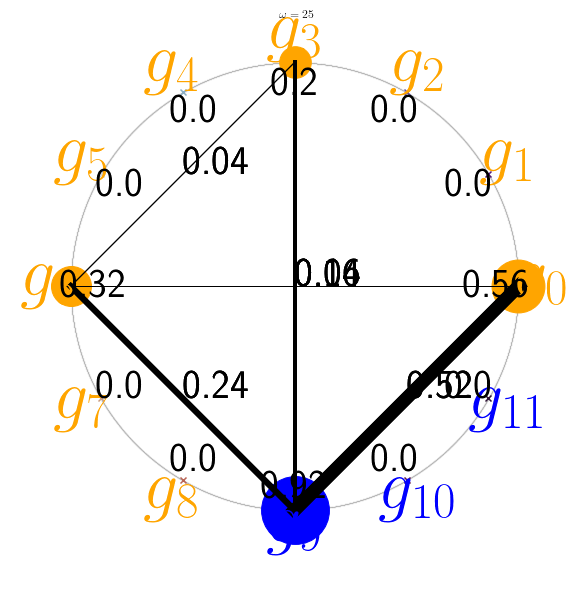

In [16]:

%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_watch_custom(toplot, 12, axes_all,colors)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_support_noise_p000001')

In [ ]:
ii_eth = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj_eth = np.asarray([1,2,3,4,5,6,7,8])
atoms4_eth,p = get_atoms_4(9,ii_eth,jj_eth)
g1 = experiment.get_g_full_sub(experiment.M.data, atoms4_eth[0])
g2 = experiment.get_g_full_sub(experiment.M.data, atoms4_eth[9])

In [ ]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g1_noise_p000001')

In [ ]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
#s = 10000
alpha = 1

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 100
#alpha = .5
selected_points = list(range(100))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{2}$', fontsize = 80, color = 'blue')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re_groundtruth_g2_noise_p000001')

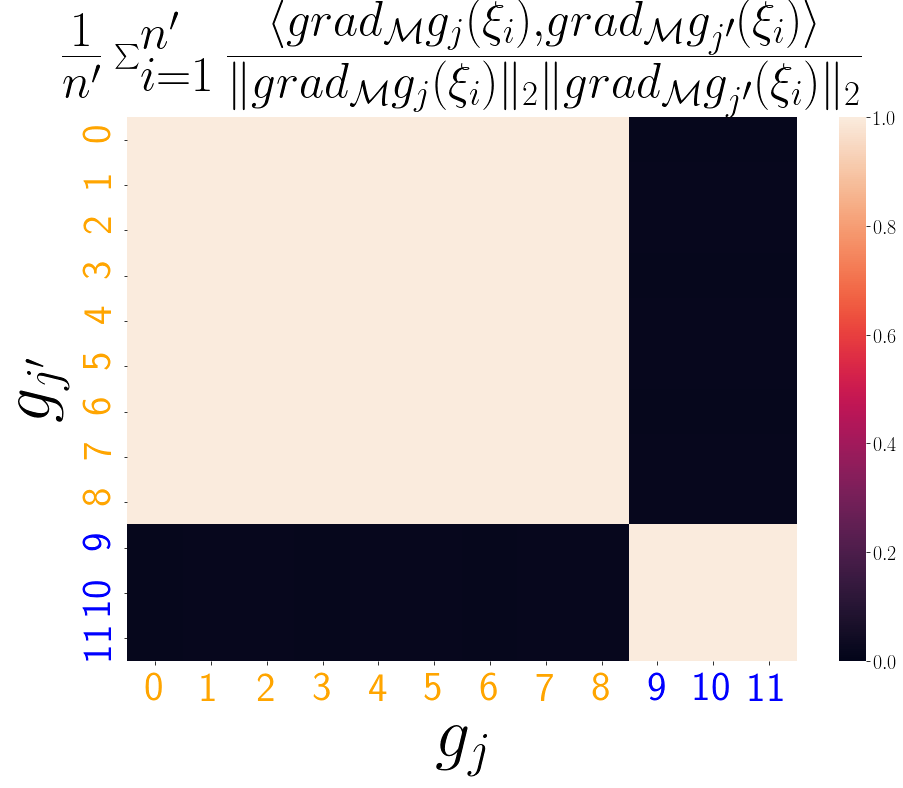

In [17]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

cosine = get_cosines(np.swapaxes(replicates[0].dg_M,1,2))
#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(cosine, axes_all, colors)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_cosines_noise')

In [18]:
def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
#     tixx = np.hstack(
#         [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
    tixx = np.hstack(
        [np.asarray([0]), 10 ** math.floor(np.log10(normax))])


    ax.set_yticks(tixx)
    #    if k != 0:
        # axes[k].set_yticks(tixx)
    ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    ax.set_xlabel(r"$\lambda  $", fontsize = 70)#\sqrt{nm}
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)


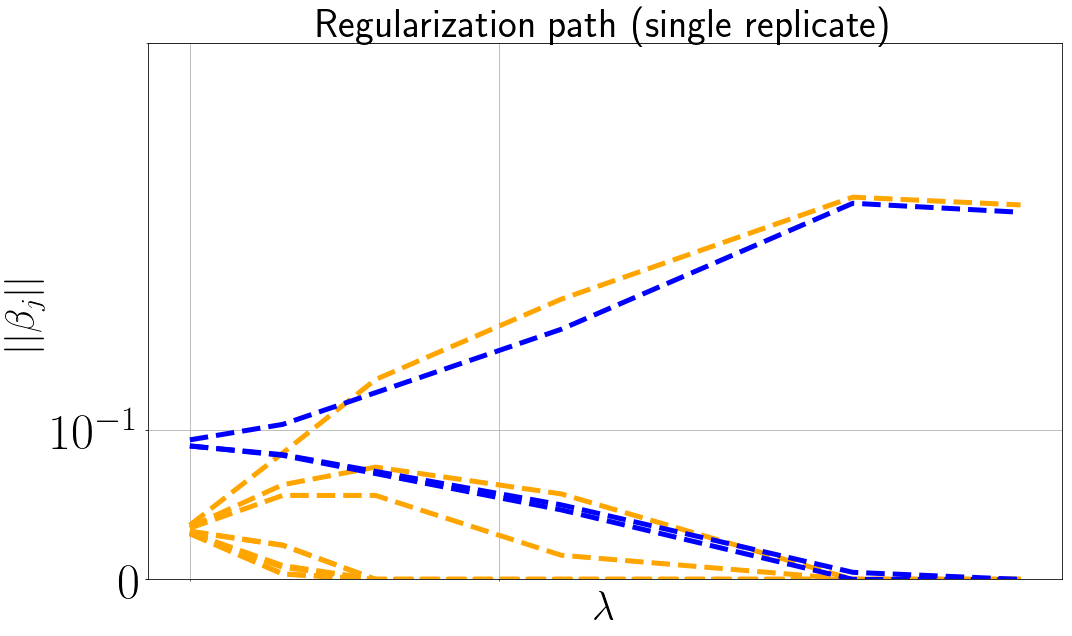

In [20]:

%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
plt.tight_layout()
axes_all.set_xlabel(r'$\lambda$', fontsize = 40)
axes_all.set_xticks([])
axes_all.set_xticklabels([])
#axarr.text(xaxis_reorder[1] * np.sqrt(3 * 5), 1.5, r'$\lambda_{-1}$', fontsize = 40)
#axarr.axvline(xaxis_reorder[2] * np.sqrt(3 * 5), color = 'black')
#axarr.text(xaxis_reorder[2] * np.sqrt(3 * 5), 1.5, r'$\lambda_{0}$', fontsize = 40)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_replicate_noise_p000001')